In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v4_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-24 04:24:23.194569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 04:24:23.195060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 04:24:23.260794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 04:24:23.261121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 04:24:23.261380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_029'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_029
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

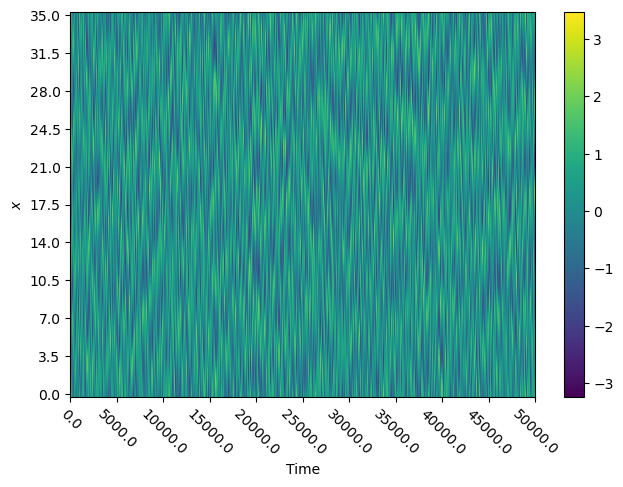

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

In [16]:
all_data.shape

(500026, 64)

# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [False]
    train_omega_in = [False]
    train_rho_res = [False]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.7361e-04 - NMSE: 0.0052 - covmat_fro_loss: 2.7724e-04 - global_gradnorm: 0.6760 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 0m 15.7s

Epoch 1: val_NMSE improved from inf to 0.00522, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Do

Epoch 9/1000
76/76 [==============================] - ETA: 0s - loss: 0.0048 - mse: 5.1721e-04 - NMSE: 0.0047 - covmat_fro_loss: 2.6489e-04 - global_gradnorm: 0.6281 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 1m 16.6s

Epoch 9: val_NMSE improved from 0.00493 to 0.00486, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0048 - mse: 5.1721e-04 - NMSE: 0.0047 - covmat_fro_loss: 2.6494e-04 - global_gradnorm: 0.6277 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0049 - val_mse: 5.3985e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 10/1000


Epoch 18/1000
76/76 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.9019e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5882e-04 - global_gradnorm: 0.5943 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 25.7s

Epoch 18: val_NMSE improved from 0.00475 to 0.00472, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 104ms/step - loss: 0.0045 - mse: 4.9019e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5891e-04 - global_gradnorm: 0.5937 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0048 - val_mse: 5.2456e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 19/100

Epoch 27/1000
76/76 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.7154e-04 - NMSE: 0.0042 - covmat_fro_loss: 2.5441e-04 - global_gradnorm: 0.5831 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 3m 34.8s

Epoch 27: val_NMSE improved from 0.00460 to 0.00457, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 103ms/step - loss: 0.0044 - mse: 4.7154e-04 - NMSE: 0.0042 - covmat_fro_loss: 2.5431e-04 - global_gradnorm: 0.5827 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0047 - val_mse: 5.0831e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 28/100

76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.5503e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5032e-04 - global_gradnorm: 0.5645 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 4m 44.0s

Epoch 36: val_NMSE improved from 0.00453 to 0.00451, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0042 - mse: 4.5503e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5038e-04 - global_gradnorm: 0.5647 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0046 - val_mse: 5.0091e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 37/1000
76/76 [=====

Epoch 45/1000
76/76 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.4376e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4756e-04 - global_gradnorm: 0.5552 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 5m 53.3s

Epoch 45: val_NMSE did not improve from 0.00439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0041 - mse: 4.4376e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4745e-04 - global_gradnorm: 0.5560 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0045 - val_mse: 4.8957e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 46/1000
76/76 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.4288e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4753e-

Epoch 54/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.3326e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4495e-04 - global_gradnorm: 0.5462 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 7m 2.2s

Epoch 54: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0040 - mse: 4.3326e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4491e-04 - global_gradnorm: 0.5460 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0044 - val_mse: 4.8008e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 55/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.3115e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4458e-04

76/76 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.2017e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.4148e-04 - global_gradnorm: 0.5240 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 10.8s

Epoch 63: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0039 - mse: 4.2017e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.4167e-04 - global_gradnorm: 0.5262 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0043 - val_mse: 4.6886e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 64/1000
76/76 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.2067e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.4169e-04 - global_gra

76/76 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.1074e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3926e-04 - global_gradnorm: 0.5165 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 9m 19.1s

Epoch 72: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0039 - mse: 4.1074e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3931e-04 - global_gradnorm: 0.5173 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0044 - val_mse: 4.7187e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 73/1000
76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.0911e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3850e-04 - global_gr

76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.9945e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3624e-04 - global_gradnorm: 0.5138 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 10m 27.5s

Epoch 81: val_NMSE did not improve from 0.00405
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0038 - mse: 3.9945e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3639e-04 - global_gradnorm: 0.5142 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0042 - val_mse: 4.5482e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 82/1000
76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.0004e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3633e-04 - global_gr

76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.9295e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3455e-04 - global_gradnorm: 0.5060 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 35.9s

Epoch 90: val_NMSE did not improve from 0.00401
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0037 - mse: 3.9295e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3453e-04 - global_gradnorm: 0.5057 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0042 - val_mse: 4.5033e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 91/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.9343e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3470e-04 - global_g

Epoch 99/1000
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.8324e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.3190e-04 - global_gradnorm: 0.4930 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 12m 44.8s

Epoch 99: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0036 - mse: 3.8324e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.3212e-04 - global_gradnorm: 0.4948 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0041 - val_mse: 4.4316e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 100/1000
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.8452e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3224

76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.7518e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2954e-04 - global_gradnorm: 0.4811 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 53.3s

Epoch 108: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0036 - mse: 3.7518e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2975e-04 - global_gradnorm: 0.4815 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0041 - val_mse: 4.3418e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 109/1000
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.7818e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.3036e-04 - global

Epoch 117/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.6953e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2806e-04 - global_gradnorm: 0.4900 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 15m 2.0s

Epoch 117: val_NMSE did not improve from 0.00380
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0035 - mse: 3.6953e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2817e-04 - global_gradnorm: 0.4898 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0040 - val_mse: 4.2344e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 118/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.6817e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2785

76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.6480e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2680e-04 - global_gradnorm: 0.4851 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 16m 10.6s

Epoch 126: val_NMSE did not improve from 0.00375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0035 - mse: 3.6480e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2679e-04 - global_gradnorm: 0.4853 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0039 - val_mse: 4.1869e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 127/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.6255e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2624e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.5534e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2418e-04 - global_gradnorm: 0.4702 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 17m 18.9s

Epoch 135: val_NMSE did not improve from 0.00370
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0034 - mse: 3.5534e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2410e-04 - global_gradnorm: 0.4702 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0039 - val_mse: 4.2186e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 136/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.5648e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2431e-04 - global

Epoch 144/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.5057e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2283e-04 - global_gradnorm: 0.4585 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 18m 28.0s

Epoch 144: val_NMSE did not improve from 0.00361
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0033 - mse: 3.5057e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2290e-04 - global_gradnorm: 0.4587 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 4.0700e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 145/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.4984e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.225

76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.4467e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2104e-04 - global_gradnorm: 0.4504 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 19m 36.2s

Epoch 153: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0033 - mse: 3.4467e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2100e-04 - global_gradnorm: 0.4506 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 3.9916e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 154/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.4206e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2030e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3794e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1896e-04 - global_gradnorm: 0.4552 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 44.7s

Epoch 162: val_NMSE improved from 0.00354 to 0.00353, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0032 - mse: 3.3794e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1893e-04 - global_gradnorm: 0.4549 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 3.9216e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 163/1000
76/76 [==

Epoch 171/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3196e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1728e-04 - global_gradnorm: 0.4468 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 21m 53.5s

Epoch 171: val_NMSE did not improve from 0.00344
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0032 - mse: 3.3196e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1750e-04 - global_gradnorm: 0.4483 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 3.9211e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 172/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3133e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.169

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0031 - mse: 3.2683e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1577e-04 - global_gradnorm: 0.4426 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 3.8765e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 181/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2611e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1540e-04 - global_gradnorm: 0.4377 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 23m 9.4s

Epoch 181: val_NMSE did not improve from 0.00342
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_

Epoch 190/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2304e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1473e-04 - global_gradnorm: 0.4424 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 17.8s

Epoch 190: val_NMSE did not improve from 0.00337
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0031 - mse: 3.2304e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1471e-04 - global_gradnorm: 0.4416 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0036 - val_mse: 3.8031e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 191/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2100e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.139

Epoch 199/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.1658e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1255e-04 - global_gradnorm: 0.4299 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 25m 26.3s

Epoch 199: val_NMSE did not improve from 0.00332
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0031 - mse: 3.1658e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1250e-04 - global_gradnorm: 0.4307 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0036 - val_mse: 3.7713e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 200/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.1590e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.12

76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1091e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1088e-04 - global_gradnorm: 0.4257 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 26m 34.8s

Epoch 208: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0030 - mse: 3.1091e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1117e-04 - global_gradnorm: 0.4261 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0036 - val_mse: 3.7586e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 209/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1098e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1092e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0030 - mse: 3.0897e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1027e-04 - global_gradnorm: 0.4240 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.6629e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 218/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.0553e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0929e-04 - global_gradnorm: 0.4178 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 27m 50.7s

Epoch 218: val_NMSE improved from 0.00326 to 0.00325, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving

76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0264e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0822e-04 - global_gradnorm: 0.4073 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 51.8s

Epoch 226: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0029 - mse: 3.0264e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0824e-04 - global_gradnorm: 0.4072 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.5907e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 227/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0117e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0774e-04 - global_

76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.9868e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0687e-04 - global_gradnorm: 0.4184 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 30m 0.4s

Epoch 235: val_NMSE did not improve from 0.00317
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0029 - mse: 2.9868e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0693e-04 - global_gradnorm: 0.4186 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.5522e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 236/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.9651e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0635e-04 - global_g

76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.9421e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0567e-04 - global_gradnorm: 0.4024 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 31m 8.6s

Epoch 244: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0029 - mse: 2.9421e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0558e-04 - global_gradnorm: 0.4023 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.5216e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 245/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.9479e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0602e-04 - global_g

76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8889e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0388e-04 - global_gradnorm: 0.3947 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 32m 17.0s

Epoch 253: val_NMSE did not improve from 0.00310
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0028 - mse: 2.8889e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0381e-04 - global_gradnorm: 0.3950 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.5273e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 254/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8909e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0393e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0028 - mse: 2.8635e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0302e-04 - global_gradnorm: 0.3965 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.4057e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 263/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8698e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0340e-04 - global_gradnorm: 0.3989 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 32.9s

Epoch 263: val_NMSE did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 272/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8164e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0153e-04 - global_gradnorm: 0.3871 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 34m 41.4s

Epoch 272: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0028 - mse: 2.8164e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0153e-04 - global_gradnorm: 0.3874 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.4040e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 273/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8241e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.01

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7902e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0064e-04 - global_gradnorm: 0.3872 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 49.9s

Epoch 281: val_NMSE did not improve from 0.00298
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 7s 99ms/step - loss: 0.0027 - mse: 2.7902e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0089e-04 - global_gradnorm: 0.3877 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.3399e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 282/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7875e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0065e-04 - global_

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7725e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0011e-04 - global_gradnorm: 0.3898 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 36m 58.3s

Epoch 290: val_NMSE improved from 0.00298 to 0.00297, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0027 - mse: 2.7725e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0032e-04 - global_gradnorm: 0.3900 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.3000e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 291/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7246e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9864e-04 - global_gradnorm: 0.3858 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 38m 7.0s

Epoch 299: val_NMSE improved from 0.00296 to 0.00296, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0027 - mse: 2.7246e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9851e-04 - global_gradnorm: 0.3860 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.2888e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 300/1000
76/76 [===

76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.6820e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9700e-04 - global_gradnorm: 0.3760 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 15.6s

Epoch 308: val_NMSE did not improve from 0.00291
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0027 - mse: 2.6820e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9707e-04 - global_gradnorm: 0.3764 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.2314e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 309/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6773e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9710e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6504e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9607e-04 - global_gradnorm: 0.3743 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 40m 24.0s

Epoch 317: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0026 - mse: 2.6504e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9620e-04 - global_gradnorm: 0.3745 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.2467e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 318/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6632e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9658e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6159e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9485e-04 - global_gradnorm: 0.3725 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 41m 32.7s

Epoch 326: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0026 - mse: 2.6159e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9503e-04 - global_gradnorm: 0.3729 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.1968e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 327/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6130e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9472e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.5947e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9422e-04 - global_gradnorm: 0.3689 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 42m 41.0s

Epoch 335: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0026 - mse: 2.5947e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9418e-04 - global_gradnorm: 0.3687 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.1627e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 336/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.5815e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9365e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5576e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9280e-04 - global_gradnorm: 0.3594 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 43m 49.6s

Epoch 344: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0025 - mse: 2.5576e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9299e-04 - global_gradnorm: 0.3600 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.1495e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 345/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.5703e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9319e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5557e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9290e-04 - global_gradnorm: 0.3615 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 58.1s

Epoch 353: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0025 - mse: 2.5557e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9282e-04 - global_gradnorm: 0.3618 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.0842e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 354/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5389e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9245e-04 - global

Epoch 363/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.4965e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9073e-04 - global_gradnorm: 0.3540 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 46m 13.8s

Epoch 363: val_NMSE improved from 0.00274 to 0.00272, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0025 - mse: 2.4965e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9062e-04 - global_gradnorm: 0.3546 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.0220e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 364

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0025 - mse: 2.4878e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9069e-04 - global_gradnorm: 0.3598 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.0622e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 373/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.4706e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8984e-04 - global_gradnorm: 0.3511 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 47m 29.7s

Epoch 373: val_NMSE improved from 0.00272 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 382/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.4520e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8918e-04 - global_gradnorm: 0.3550 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 38.3s

Epoch 382: val_NMSE did not improve from 0.00267
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0025 - mse: 2.4520e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8926e-04 - global_gradnorm: 0.3558 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.0238e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 383/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.4478e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.89

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0024 - mse: 2.4143e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8776e-04 - global_gradnorm: 0.3459 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.9147e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 392/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4274e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8831e-04 - global_gradnorm: 0.3547 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 49m 54.3s

Epoch 392: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 401/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4018e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8744e-04 - global_gradnorm: 0.3521 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 51m 2.4s

Epoch 401: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0024 - mse: 2.4018e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8735e-04 - global_gradnorm: 0.3522 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 2.9867e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 402/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4004e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8749

Epoch 411/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.3877e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8702e-04 - global_gradnorm: 0.3483 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 18.0s

Epoch 411: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0024 - mse: 2.3877e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8719e-04 - global_gradnorm: 0.3483 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 2.9344e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 412/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.3685e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.861

76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.3515e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8555e-04 - global_gradnorm: 0.3404 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 53m 26.3s

Epoch 420: val_NMSE improved from 0.00261 to 0.00261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0024 - mse: 2.3515e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8533e-04 - global_gradnorm: 0.3406 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.8974e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 421/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3225e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8460e-04 - global_gradnorm: 0.3382 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 54m 35.2s

Epoch 429: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0023 - mse: 2.3225e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8452e-04 - global_gradnorm: 0.3385 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.8581e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 430/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3143e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8411e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0023 - mse: 2.2938e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8367e-04 - global_gradnorm: 0.3287 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.8141e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 439/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2960e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8365e-04 - global_gradnorm: 0.3304 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 51.4s

Epoch 439: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 448/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2736e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8282e-04 - global_gradnorm: 0.3368 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 56m 59.2s

Epoch 448: val_NMSE improved from 0.00253 to 0.00253, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0023 - mse: 2.2736e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8283e-04 - global_gradnorm: 0.3369 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.8137e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 449

76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2453e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8178e-04 - global_gradnorm: 0.3234 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 58m 8.1s

Epoch 457: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0023 - mse: 2.2453e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8183e-04 - global_gradnorm: 0.3239 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.8027e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 458/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2423e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8167e-04 - global_

Epoch 467/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2325e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8130e-04 - global_gradnorm: 0.3249 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 23.5s

Epoch 467: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0023 - mse: 2.2325e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8142e-04 - global_gradnorm: 0.3252 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.7765e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 468/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2364e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.81

Epoch 477/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2113e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8046e-04 - global_gradnorm: 0.3273 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 0m 39.3s

Epoch 477: val_NMSE improved from 0.00248 to 0.00247, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 103ms/step - loss: 0.0023 - mse: 2.2113e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8053e-04 - global_gradnorm: 0.3276 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.7482e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 478/

76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1914e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7967e-04 - global_gradnorm: 0.3198 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 1m 47.8s

Epoch 486: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0022 - mse: 2.1914e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7988e-04 - global_gradnorm: 0.3199 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.7577e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 487/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1952e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7978e-04 - global_

Epoch 496/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1670e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7871e-04 - global_gradnorm: 0.3230 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 3m 3.9s

Epoch 496: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0022 - mse: 2.1670e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7861e-04 - global_gradnorm: 0.3238 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.7999e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 497/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1601e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7867

76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1531e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7837e-04 - global_gradnorm: 0.3197 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 12.9s

Epoch 505: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 99ms/step - loss: 0.0022 - mse: 2.1531e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7830e-04 - global_gradnorm: 0.3199 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.7097e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 506/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1417e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7779e-04 - global_g

Epoch 515/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1348e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7760e-04 - global_gradnorm: 0.3158 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 5m 29.3s

Epoch 515: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0022 - mse: 2.1348e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7751e-04 - global_gradnorm: 0.3162 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.6929e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 516/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1307e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.773

Epoch 525/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1087e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7672e-04 - global_gradnorm: 0.3125 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 45.8s

Epoch 525: val_NMSE improved from 0.00237 to 0.00234, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0022 - mse: 2.1087e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7661e-04 - global_gradnorm: 0.3121 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0026 - val_mse: 2.5987e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 526/

76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0799e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7555e-04 - global_gradnorm: 0.3100 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 7m 54.8s

Epoch 534: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0021 - mse: 2.0799e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7547e-04 - global_gradnorm: 0.3100 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0026 - val_mse: 2.6391e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 535/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0874e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7573e-04 - global_

Epoch 544/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0657e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7493e-04 - global_gradnorm: 0.3068 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 9m 11.5s

Epoch 544: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0021 - mse: 2.0657e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7490e-04 - global_gradnorm: 0.3066 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0026 - val_mse: 2.5932e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 545/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0718e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.752

Epoch 554/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0372e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7386e-04 - global_gradnorm: 0.2944 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 10m 27.8s

Epoch 554: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0021 - mse: 2.0372e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7381e-04 - global_gradnorm: 0.2941 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0026 - val_mse: 2.5894e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 555/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0437e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.74

76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0386e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7394e-04 - global_gradnorm: 0.3035 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 36.7s

Epoch 563: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0021 - mse: 2.0386e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7413e-04 - global_gradnorm: 0.3044 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0026 - val_mse: 2.5966e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 564/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0330e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7357e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0273e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7345e-04 - global_gradnorm: 0.2993 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 12m 45.8s

Epoch 572: val_NMSE improved from 0.00229 to 0.00228, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 104ms/step - loss: 0.0021 - mse: 2.0273e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7338e-04 - global_gradnorm: 0.2985 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.5378e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 573/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9970e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7230e-04 - global_gradnorm: 0.2975 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 13m 54.9s

Epoch 581: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0021 - mse: 1.9970e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7227e-04 - global_gradnorm: 0.2975 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.5255e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 582/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9928e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7202e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0021 - mse: 1.9822e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7150e-04 - global_gradnorm: 0.2951 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.5200e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 591/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9803e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7155e-04 - global_gradnorm: 0.2967 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 15m 11.3s

Epoch 591: val_NMSE improved from 0.00226 to 0.00225, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 600/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9615e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7074e-04 - global_gradnorm: 0.2942 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 16m 20.6s

Epoch 600: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0020 - mse: 1.9615e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7074e-04 - global_gradnorm: 0.2946 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.5152e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 601/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9682e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.71

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 103ms/step - loss: 0.0020 - mse: 1.9497e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7030e-04 - global_gradnorm: 0.2911 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.4450e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 610/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9509e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7040e-04 - global_gradnorm: 0.2891 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 37.1s

Epoch 610: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 619/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9559e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7053e-04 - global_gradnorm: 0.3046 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 18m 45.9s

Epoch 619: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0020 - mse: 1.9559e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7067e-04 - global_gradnorm: 0.3045 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.4546e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 620/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9348e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.69

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0020 - mse: 1.9364e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6971e-04 - global_gradnorm: 0.2958 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0025 - val_mse: 2.4613e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 629/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9227e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6915e-04 - global_gradnorm: 0.2924 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 20m 2.6s

Epoch 629: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5

Epoch 638/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9019e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6829e-04 - global_gradnorm: 0.2847 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 11.5s

Epoch 638: val_NMSE did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 102ms/step - loss: 0.0020 - mse: 1.9019e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6846e-04 - global_gradnorm: 0.2846 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.4388e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 639/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8992e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.68

76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8932e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6806e-04 - global_gradnorm: 0.2863 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 22m 20.5s

Epoch 647: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0020 - mse: 1.8932e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6793e-04 - global_gradnorm: 0.2862 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.4385e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 648/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9053e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6856e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 101ms/step - loss: 0.0020 - mse: 1.8822e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6767e-04 - global_gradnorm: 0.2862 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.4280e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 657/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8694e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6702e-04 - global_gradnorm: 0.2798 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 23m 37.0s

Epoch 657: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 666/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8596e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6664e-04 - global_gradnorm: 0.2753 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 45.9s

Epoch 666: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 100ms/step - loss: 0.0020 - mse: 1.8596e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6674e-04 - global_gradnorm: 0.2757 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3958e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 667/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8676e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.67

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0020 - mse: 1.8558e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6651e-04 - global_gradnorm: 0.2879 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3802e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 676/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8511e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6635e-04 - global_gradnorm: 0.2811 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 4.8s

Epoch 676: val_NMSE improved from 0.00213 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving 

Epoch 685/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8350e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6559e-04 - global_gradnorm: 0.2769 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 27m 17.5s

Epoch 685: val_NMSE did not improve from 0.00210
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0019 - mse: 1.8350e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6569e-04 - global_gradnorm: 0.2767 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3608e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 686/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8451e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.66

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0019 - mse: 1.8240e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6534e-04 - global_gradnorm: 0.2756 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3745e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 695/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8234e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6514e-04 - global_gradnorm: 0.2766 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 38.0s

Epoch 695: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 704/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8135e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6476e-04 - global_gradnorm: 0.2696 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 29m 50.5s

Epoch 704: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0019 - mse: 1.8135e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6485e-04 - global_gradnorm: 0.2698 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3277e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 705/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8087e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.64

76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7969e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6402e-04 - global_gradnorm: 0.2696 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 31m 3.4s

Epoch 713: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0019 - mse: 1.7969e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6399e-04 - global_gradnorm: 0.2701 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3405e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 714/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8090e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6470e-04 - global_

76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7948e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6390e-04 - global_gradnorm: 0.2766 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 32m 16.2s

Epoch 722: val_NMSE did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0019 - mse: 1.7948e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6391e-04 - global_gradnorm: 0.2767 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.3022e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 723/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7785e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6323e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7830e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6352e-04 - global_gradnorm: 0.2706 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 33m 29.4s

Epoch 731: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0019 - mse: 1.7830e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6344e-04 - global_gradnorm: 0.2710 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0024 - val_mse: 2.3204e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 732/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7784e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6324e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0019 - mse: 1.7679e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6277e-04 - global_gradnorm: 0.2721 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2965e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 741/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7701e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6297e-04 - global_gradnorm: 0.2753 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 34m 50.2s

Epoch 741: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 750/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7630e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6268e-04 - global_gradnorm: 0.2745 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 36m 3.1s

Epoch 750: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0019 - mse: 1.7630e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6257e-04 - global_gradnorm: 0.2744 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2892e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 751/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7527e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.622

76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7453e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6186e-04 - global_gradnorm: 0.2695 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 37m 16.4s

Epoch 759: val_NMSE did not improve from 0.00201
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0019 - mse: 1.7453e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6190e-04 - global_gradnorm: 0.2696 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2557e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 760/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7436e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6186e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0019 - mse: 1.7314e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6118e-04 - global_gradnorm: 0.2687 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2445e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 769/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7393e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6166e-04 - global_gradnorm: 0.2723 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 38m 37.4s

Epoch 769: val_NMSE did not improve from 0.00201
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 778/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7244e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6106e-04 - global_gradnorm: 0.2639 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 39m 50.2s

Epoch 778: val_NMSE did not improve from 0.00197
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0018 - mse: 1.7244e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6120e-04 - global_gradnorm: 0.2644 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2385e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 779/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7261e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.61

Epoch 788/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7053e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6018e-04 - global_gradnorm: 0.2617 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 41m 10.8s

Epoch 788: val_NMSE did not improve from 0.00197
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0018 - mse: 1.7053e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6016e-04 - global_gradnorm: 0.2613 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2267e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 789/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7144e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.60

Epoch 798/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6926e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5951e-04 - global_gradnorm: 0.2611 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 42m 31.5s

Epoch 798: val_NMSE did not improve from 0.00197
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0018 - mse: 1.6926e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5943e-04 - global_gradnorm: 0.2612 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0023 - val_mse: 2.2229e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 799/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6969e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.59

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0018 - mse: 1.6771e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5912e-04 - global_gradnorm: 0.2519 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1735e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 808/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6751e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5872e-04 - global_gradnorm: 0.2512 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 43m 52.3s

Epoch 808: val_NMSE did not improve from 0.00195
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 817/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6693e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5862e-04 - global_gradnorm: 0.2540 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 45m 5.1s

Epoch 817: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0018 - mse: 1.6693e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5867e-04 - global_gradnorm: 0.2538 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1792e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 818/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6706e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.586

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0018 - mse: 1.6630e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5839e-04 - global_gradnorm: 0.2495 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1735e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 827/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6664e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5842e-04 - global_gradnorm: 0.2640 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 46m 25.9s

Epoch 827: val_NMSE improved from 0.00194 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 836/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6677e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5855e-04 - global_gradnorm: 0.2641 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 47m 38.6s

Epoch 836: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0018 - mse: 1.6677e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5857e-04 - global_gradnorm: 0.2638 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1647e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 837/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6491e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.57

76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6357e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5714e-04 - global_gradnorm: 0.2493 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 48m 51.7s

Epoch 845: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 104ms/step - loss: 0.0018 - mse: 1.6357e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5719e-04 - global_gradnorm: 0.2493 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1236e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 846/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6434e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5739e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0018 - mse: 1.6346e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5690e-04 - global_gradnorm: 0.2551 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1426e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 855/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6340e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5696e-04 - global_gradnorm: 0.2505 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 50m 12.6s

Epoch 855: val_NMSE improved from 0.00191 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 864/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6271e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5664e-04 - global_gradnorm: 0.2510 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 51m 25.2s

Epoch 864: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0018 - mse: 1.6271e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5672e-04 - global_gradnorm: 0.2510 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1192e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 865/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6183e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.56

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0018 - mse: 1.6100e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5598e-04 - global_gradnorm: 0.2478 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.0831e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 874/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6071e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5581e-04 - global_gradnorm: 0.2446 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 52m 46.2s

Epoch 874: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 883/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6039e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5563e-04 - global_gradnorm: 0.2504 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 53m 58.9s

Epoch 883: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0017 - mse: 1.6039e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5569e-04 - global_gradnorm: 0.2505 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1115e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 884/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6027e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.55

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0017 - mse: 1.5945e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5522e-04 - global_gradnorm: 0.2483 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.1017e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 893/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5958e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5523e-04 - global_gradnorm: 0.2499 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 55m 19.8s

Epoch 893: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 902/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5905e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5508e-04 - global_gradnorm: 0.2497 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 56m 32.3s

Epoch 902: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0017 - mse: 1.5905e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5515e-04 - global_gradnorm: 0.2497 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0710e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 903/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5838e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.54

Epoch 912/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5706e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5418e-04 - global_gradnorm: 0.2366 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 57m 52.8s

Epoch 912: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0017 - mse: 1.5706e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5414e-04 - global_gradnorm: 0.2365 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.0881e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 913/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5811e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.54

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0017 - mse: 1.5803e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5464e-04 - global_gradnorm: 0.2538 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0022 - val_mse: 2.0938e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 922/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5722e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5426e-04 - global_gradnorm: 0.2471 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 59m 13.7s

Epoch 922: val_NMSE did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 931/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5595e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5368e-04 - global_gradnorm: 0.2391 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 0m 26.5s

Epoch 931: val_NMSE improved from 0.00184 to 0.00183, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0017 - mse: 1.5595e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5373e-04 - global_gradnorm: 0.2389 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0337e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 932/

76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5537e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5338e-04 - global_gradnorm: 0.2421 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 1m 39.0s

Epoch 940: val_NMSE improved from 0.00183 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0017 - mse: 1.5537e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5337e-04 - global_gradnorm: 0.2417 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0161e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 941/1000
76/76 [===

Epoch 950/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5467e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5307e-04 - global_gradnorm: 0.2434 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 2m 59.8s

Epoch 950: val_NMSE improved from 0.00181 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0017 - mse: 1.5467e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5307e-04 - global_gradnorm: 0.2433 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0157e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 951/

76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5374e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5269e-04 - global_gradnorm: 0.2370 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 4m 13.0s

Epoch 959: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0017 - mse: 1.5374e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5268e-04 - global_gradnorm: 0.2369 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0456e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 960/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5358e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5255e-04 - global_

Epoch 969/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5229e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5192e-04 - global_gradnorm: 0.2344 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 5m 33.4s

Epoch 969: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0017 - mse: 1.5229e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5188e-04 - global_gradnorm: 0.2346 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0550e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 970/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5224e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.520

76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5187e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5187e-04 - global_gradnorm: 0.2346 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 6m 46.4s

Epoch 978: val_NMSE did not improve from 0.00178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0017 - mse: 1.5187e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5182e-04 - global_gradnorm: 0.2345 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0217e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 979/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5141e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5159e-04 - global_

Epoch 988/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5152e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5169e-04 - global_gradnorm: 0.2381 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 8m 7.1s

Epoch 988: val_NMSE did not improve from 0.00178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0017 - mse: 1.5152e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5166e-04 - global_gradnorm: 0.2383 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 2.0311e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 989/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5142e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5160

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 105ms/step - loss: 0.0017 - mse: 1.5028e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5113e-04 - global_gradnorm: 0.2321 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0021 - val_mse: 1.9826e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 998/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5022e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5096e-04 - global_gradnorm: 0.2324 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 9m 27.7s

Epoch 998: val_NMSE improved from 0.00177 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-5_outsteps
 - saving 

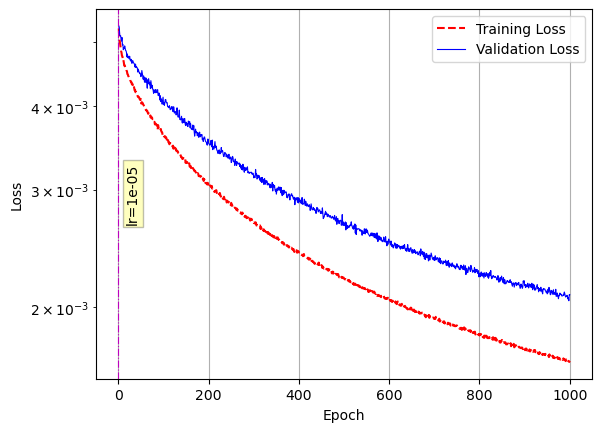

<Figure size 640x480 with 0 Axes>

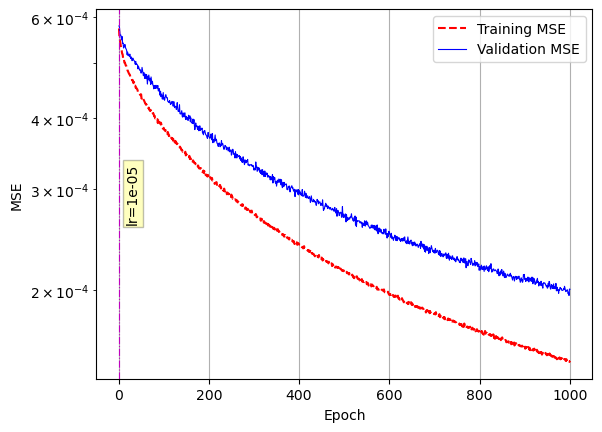

<Figure size 640x480 with 0 Axes>

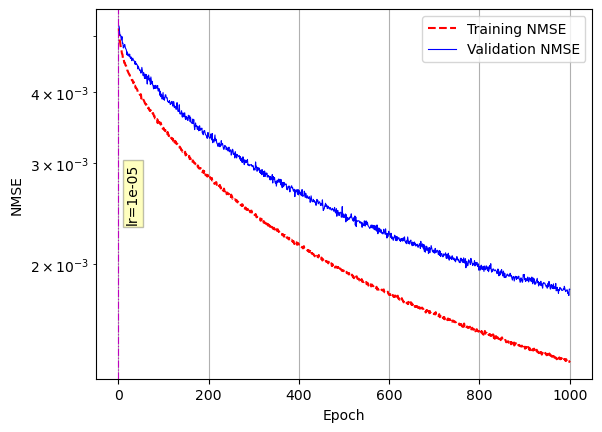

<Figure size 640x480 with 0 Axes>

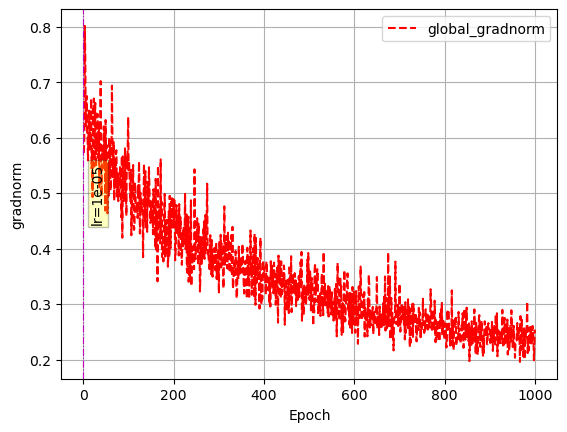

<Figure size 640x480 with 0 Axes>

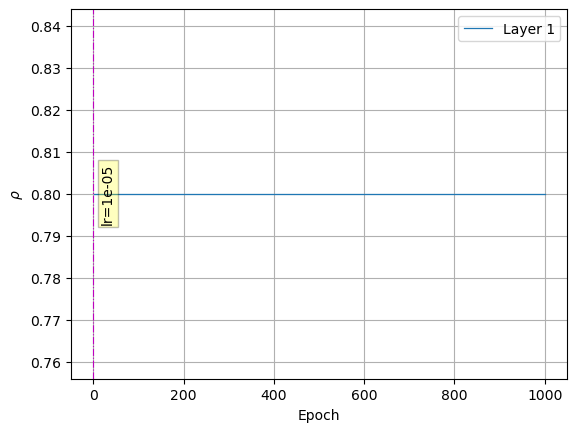

<Figure size 640x480 with 0 Axes>

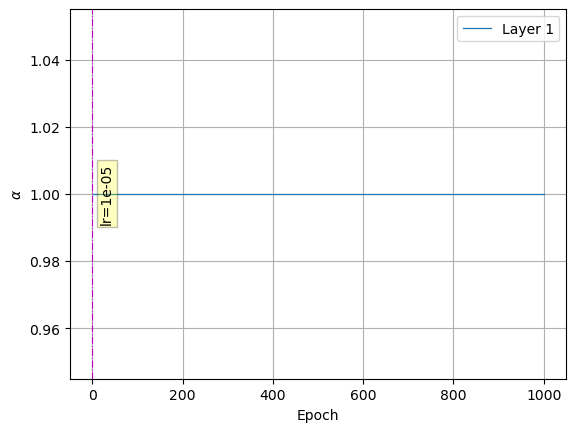

<Figure size 640x480 with 0 Axes>

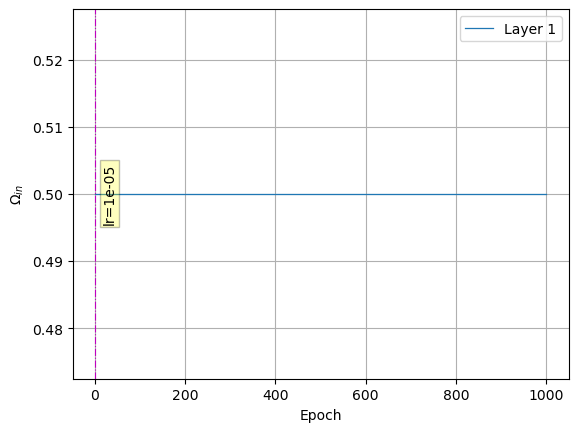



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.7514e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6254e-04 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 0m 20.2s

Epoch 1: val_NMSE improved from inf to 0.00433, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/D

71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.2700e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4192e-04 - global_gradnorm: 0.7449 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 1m 28.8s

Epoch 9: val_NMSE did not improve from 0.00414
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0038 - mse: 4.2700e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4171e-04 - global_gradnorm: 0.7450 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0041 - val_mse: 4.7215e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 10/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.2455e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4015e-04 - global_gr

71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.1457e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3620e-04 - global_gradnorm: 0.7378 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 46.1s

Epoch 18: val_NMSE did not improve from 0.00410
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0037 - mse: 4.1457e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3608e-04 - global_gradnorm: 0.7380 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0041 - val_mse: 4.6897e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 19/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.1541e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3649e-04 - global_g

Epoch 28/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.0590e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3239e-04 - global_gradnorm: 0.7380 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 4m 11.1s

Epoch 28: val_NMSE did not improve from 0.00410
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0036 - mse: 4.0590e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3287e-04 - global_gradnorm: 0.7382 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0040 - val_mse: 4.6300e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 29/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.0247e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3089e

71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.9520e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2754e-04 - global_gradnorm: 0.7332 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 5m 28.1s

Epoch 37: val_NMSE improved from 0.00406 to 0.00404, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0035 - mse: 3.9520e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2750e-04 - global_gradnorm: 0.7335 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0039 - val_mse: 4.4871e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 38/1000
71/71 [===

71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.9091e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2508e-04 - global_gradnorm: 0.7317 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 6m 45.0s

Epoch 46: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0035 - mse: 3.9091e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2546e-04 - global_gradnorm: 0.7319 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0041 - val_mse: 4.6987e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.8700e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2347e-04 - global_g

Epoch 56/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.8284e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2128e-04 - global_gradnorm: 0.7094 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 10.3s

Epoch 56: val_NMSE improved from 0.00390 to 0.00388, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0034 - mse: 3.8284e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2097e-04 - global_gradnorm: 0.7079 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 4.3088e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 57/1

Epoch 66/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7746e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1901e-04 - global_gradnorm: 0.7153 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 9m 35.6s

Epoch 66: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0034 - mse: 3.7746e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1874e-04 - global_gradnorm: 0.7145 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0039 - val_mse: 4.4728e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 67/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7667e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1805e

Epoch 76/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.7302e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1656e-04 - global_gradnorm: 0.7227 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 1.0s

Epoch 76: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0033 - mse: 3.7302e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1670e-04 - global_gradnorm: 0.7229 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0039 - val_mse: 4.4580e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 77/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.7299e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1653e

Epoch 86/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6968e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1458e-04 - global_gradnorm: 0.7157 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 12m 26.3s

Epoch 86: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0033 - mse: 3.6968e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1450e-04 - global_gradnorm: 0.7161 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 4.3371e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 87/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6698e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1372

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5964e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0996e-04 - global_gradnorm: 0.6931 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 43.3s

Epoch 95: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0032 - mse: 3.5964e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1004e-04 - global_gradnorm: 0.6939 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 4.3407e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 96/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6160e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1062e-04 - global_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0032 - mse: 3.5946e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0928e-04 - global_gradnorm: 0.7046 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 4.3526e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 105/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5709e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0827e-04 - global_gradnorm: 0.6897 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 15m 8.5s

Epoch 105: val_NMSE did not improve from 0.00382
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 114/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5279e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0600e-04 - global_gradnorm: 0.6965 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 16m 25.5s

Epoch 114: val_NMSE improved from 0.00382 to 0.00376, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0032 - mse: 3.5279e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0587e-04 - global_gradnorm: 0.6958 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 4.1739e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 1

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5015e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0456e-04 - global_gradnorm: 0.6876 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 17m 42.3s

Epoch 123: val_NMSE did not improve from 0.00375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0032 - mse: 3.5015e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0481e-04 - global_gradnorm: 0.6881 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0038 - val_mse: 4.3068e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 124/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5288e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0597e-04 - globa

Epoch 133/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4782e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0329e-04 - global_gradnorm: 0.6774 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 19m 7.2s

Epoch 133: val_NMSE did not improve from 0.00375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0031 - mse: 3.4782e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0292e-04 - global_gradnorm: 0.6777 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 4.2030e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 134/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4192e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.00

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4373e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0076e-04 - global_gradnorm: 0.6688 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 23.5s

Epoch 142: val_NMSE did not improve from 0.00372
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0031 - mse: 3.4373e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0084e-04 - global_gradnorm: 0.6693 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 4.1943e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 143/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4328e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0121e-04 - globa

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4082e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9960e-04 - global_gradnorm: 0.6841 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 21m 40.1s

Epoch 151: val_NMSE did not improve from 0.00370
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0031 - mse: 3.4082e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9917e-04 - global_gradnorm: 0.6840 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 4.1370e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 152/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4023e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9909e-04 - globa

Epoch 161/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.3859e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9859e-04 - global_gradnorm: 0.6768 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 23m 5.1s

Epoch 161: val_NMSE improved from 0.00370 to 0.00369, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0031 - mse: 3.3859e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9910e-04 - global_gradnorm: 0.6770 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0036 - val_mse: 4.0976e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 16

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.3408e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9604e-04 - global_gradnorm: 0.6736 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 21.9s

Epoch 170: val_NMSE did not improve from 0.00366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0030 - mse: 3.3408e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9575e-04 - global_gradnorm: 0.6733 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0036 - val_mse: 4.1098e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 171/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.3223e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9503e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0030 - mse: 3.3394e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9596e-04 - global_gradnorm: 0.6768 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.9932e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 180/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.3227e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9482e-04 - global_gradnorm: 0.6694 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 25m 47.3s

Epoch 180: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 189/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2901e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9309e-04 - global_gradnorm: 0.6669 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 27m 4.0s

Epoch 189: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0030 - mse: 3.2901e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9299e-04 - global_gradnorm: 0.6660 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0037 - val_mse: 4.1343e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 190/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2770e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.92

Epoch 199/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2617e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9160e-04 - global_gradnorm: 0.6757 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 28.9s

Epoch 199: val_NMSE did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0030 - mse: 3.2617e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9177e-04 - global_gradnorm: 0.6767 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0036 - val_mse: 4.0279e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 200/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2335e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9

71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.2133e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8866e-04 - global_gradnorm: 0.6477 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 29m 45.7s

Epoch 208: val_NMSE did not improve from 0.00353
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0029 - mse: 3.2133e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8875e-04 - global_gradnorm: 0.6492 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.9939e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 209/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.2005e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8820e-04 - globa

Epoch 218/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1957e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8797e-04 - global_gradnorm: 0.6401 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 31m 11.0s

Epoch 218: val_NMSE did not improve from 0.00353
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0029 - mse: 3.1957e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8784e-04 - global_gradnorm: 0.6397 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.9317e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 219/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1976e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8

Epoch 228/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1527e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8508e-04 - global_gradnorm: 0.6510 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 32m 36.2s

Epoch 228: val_NMSE did not improve from 0.00353
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0029 - mse: 3.1527e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8500e-04 - global_gradnorm: 0.6524 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.9596e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 229/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1525e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8

71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1452e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8516e-04 - global_gradnorm: 0.6576 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 52.8s

Epoch 237: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0029 - mse: 3.1452e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8541e-04 - global_gradnorm: 0.6582 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.9682e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 238/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1518e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8506e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0029 - mse: 3.1106e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8331e-04 - global_gradnorm: 0.6330 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.8828e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 247/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1152e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8348e-04 - global_gradnorm: 0.6368 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 17.1s

Epoch 247: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 256/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0750e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8063e-04 - global_gradnorm: 0.6180 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 36m 32.7s

Epoch 256: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0028 - mse: 3.0750e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8031e-04 - global_gradnorm: 0.6173 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.8924e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 257/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0953e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8

Epoch 266/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0652e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8042e-04 - global_gradnorm: 0.6365 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 37m 56.9s

Epoch 266: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0028 - mse: 3.0652e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8048e-04 - global_gradnorm: 0.6368 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.8892e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 267/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0558e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0028 - mse: 3.0271e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7787e-04 - global_gradnorm: 0.6271 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.8078e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 276/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0370e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7867e-04 - global_gradnorm: 0.6252 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 21.1s

Epoch 276: val_NMSE improved from 0.00343 to 0.00342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - savi

Epoch 285/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0132e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7725e-04 - global_gradnorm: 0.6280 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 40m 36.5s

Epoch 285: val_NMSE did not improve from 0.00342
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 117ms/step - loss: 0.0028 - mse: 3.0132e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7745e-04 - global_gradnorm: 0.6285 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.8138e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 286/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0318e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0028 - mse: 3.0092e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7664e-04 - global_gradnorm: 0.6297 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0035 - val_mse: 3.8890e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 295/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9952e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7579e-04 - global_gradnorm: 0.6290 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 42m 0.9s

Epoch 295: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 304/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9689e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7495e-04 - global_gradnorm: 0.6162 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 43m 16.5s

Epoch 304: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 117ms/step - loss: 0.0027 - mse: 2.9689e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7492e-04 - global_gradnorm: 0.6164 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.8020e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 305/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0009e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0027 - mse: 2.9264e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7288e-04 - global_gradnorm: 0.5989 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.7816e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 314/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9500e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7374e-04 - global_gradnorm: 0.6092 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 40.6s

Epoch 314: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 323/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9532e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7354e-04 - global_gradnorm: 0.6230 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 45m 56.1s

Epoch 323: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0027 - mse: 2.9532e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7336e-04 - global_gradnorm: 0.6245 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.7777e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 324/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9037e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0027 - mse: 2.8919e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7023e-04 - global_gradnorm: 0.5910 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.6538e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 333/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8993e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7043e-04 - global_gradnorm: 0.5969 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 47m 20.1s

Epoch 333: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 342/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8826e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6937e-04 - global_gradnorm: 0.6005 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 35.7s

Epoch 342: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0027 - mse: 2.8826e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6963e-04 - global_gradnorm: 0.6011 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.7745e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 343/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8927e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7

Epoch 352/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8635e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6809e-04 - global_gradnorm: 0.5919 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 49m 59.6s

Epoch 352: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0027 - mse: 2.8635e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6827e-04 - global_gradnorm: 0.5933 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0034 - val_mse: 3.7836e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 353/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8697e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0027 - mse: 2.8692e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6817e-04 - global_gradnorm: 0.6075 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.6516e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 362/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8237e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6584e-04 - global_gradnorm: 0.5730 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 51m 23.9s

Epoch 362: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 371/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8296e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6595e-04 - global_gradnorm: 0.5965 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 39.7s

Epoch 371: val_NMSE did not improve from 0.00328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0026 - mse: 2.8296e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6604e-04 - global_gradnorm: 0.5974 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.6881e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 372/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8143e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0026 - mse: 2.8184e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6553e-04 - global_gradnorm: 0.5919 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.6284e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 381/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8011e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6442e-04 - global_gradnorm: 0.5814 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 54m 4.0s

Epoch 381: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 390/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7889e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6348e-04 - global_gradnorm: 0.5889 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 19.9s

Epoch 390: val_NMSE improved from 0.00322 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0026 - mse: 2.7889e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6318e-04 - global_gradnorm: 0.5873 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5655e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 3

71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7872e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6369e-04 - global_gradnorm: 0.5912 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 56m 36.0s

Epoch 399: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0026 - mse: 2.7872e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6334e-04 - global_gradnorm: 0.5915 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.6080e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 400/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7788e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6308e-04 - globa

71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7565e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6194e-04 - global_gradnorm: 0.5791 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 57m 51.9s

Epoch 408: val_NMSE did not improve from 0.00316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 117ms/step - loss: 0.0026 - mse: 2.7565e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6160e-04 - global_gradnorm: 0.5783 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0033 - val_mse: 3.6320e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 409/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7344e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6002e-04 - globa

Epoch 418/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7458e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6099e-04 - global_gradnorm: 0.5902 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 16.1s

Epoch 418: val_NMSE did not improve from 0.00316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0026 - mse: 2.7458e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6073e-04 - global_gradnorm: 0.5917 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5451e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 419/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7346e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0025 - mse: 2.7119e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5882e-04 - global_gradnorm: 0.5679 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5478e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 428/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7235e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5964e-04 - global_gradnorm: 0.5795 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 0m 40.1s

Epoch 428: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 437/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6681e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5616e-04 - global_gradnorm: 0.5525 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 1m 56.0s

Epoch 437: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0025 - mse: 2.6681e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5622e-04 - global_gradnorm: 0.5511 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5692e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 438/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6991e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.58

Epoch 447/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6550e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5510e-04 - global_gradnorm: 0.5409 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 3m 20.3s

Epoch 447: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0025 - mse: 2.6550e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5530e-04 - global_gradnorm: 0.5422 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5172e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 448/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6652e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.56

Epoch 457/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6582e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5560e-04 - global_gradnorm: 0.5549 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 44.8s

Epoch 457: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0025 - mse: 2.6582e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5555e-04 - global_gradnorm: 0.5545 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.4724e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 458/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6440e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.54

Epoch 467/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6551e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5521e-04 - global_gradnorm: 0.5594 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 8.3s

Epoch 467: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0025 - mse: 2.6551e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5514e-04 - global_gradnorm: 0.5590 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5686e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 468/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6433e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.545

71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6483e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5486e-04 - global_gradnorm: 0.5662 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 7m 24.2s

Epoch 476: val_NMSE improved from 0.00309 to 0.00309, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0025 - mse: 2.6483e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5460e-04 - global_gradnorm: 0.5655 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.4313e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 477/1000
71/71 [=

71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6157e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5304e-04 - global_gradnorm: 0.5440 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 8m 40.0s

Epoch 485: val_NMSE did not improve from 0.00304
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0025 - mse: 2.6157e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5295e-04 - global_gradnorm: 0.5438 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.4868e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 486/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6100e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5242e-04 - global

Epoch 495/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6181e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5292e-04 - global_gradnorm: 0.5613 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 10m 4.2s

Epoch 495: val_NMSE did not improve from 0.00304
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0025 - mse: 2.6181e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5351e-04 - global_gradnorm: 0.5605 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.4213e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 496/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6058e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.51

Epoch 505/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5855e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5108e-04 - global_gradnorm: 0.5574 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 28.2s

Epoch 505: val_NMSE did not improve from 0.00304
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0024 - mse: 2.5855e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5095e-04 - global_gradnorm: 0.5579 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.4853e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 506/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6007e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0025 - mse: 2.6015e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5226e-04 - global_gradnorm: 0.5612 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0032 - val_mse: 3.5063e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 515/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5724e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4983e-04 - global_gradnorm: 0.5446 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 12m 52.3s

Epoch 515: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 524/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5678e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4960e-04 - global_gradnorm: 0.5482 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 14m 8.1s

Epoch 524: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0024 - mse: 2.5678e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4933e-04 - global_gradnorm: 0.5484 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.4158e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 525/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5701e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.50

71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5289e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4697e-04 - global_gradnorm: 0.5305 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 15m 24.0s

Epoch 533: val_NMSE did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0024 - mse: 2.5289e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4688e-04 - global_gradnorm: 0.5295 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.4246e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 534/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5387e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4759e-04 - globa

71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5271e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4725e-04 - global_gradnorm: 0.5303 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 16m 40.6s

Epoch 542: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0024 - mse: 2.5271e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4738e-04 - global_gradnorm: 0.5303 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.3773e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 543/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5304e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4726e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0024 - mse: 2.5224e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4643e-04 - global_gradnorm: 0.5417 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.3934e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 552/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5265e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4675e-04 - global_gradnorm: 0.5426 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 18m 4.9s

Epoch 552: val_NMSE improved from 0.00301 to 0.00300, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - savin

Epoch 561/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4906e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4468e-04 - global_gradnorm: 0.5301 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 21.0s

Epoch 561: val_NMSE did not improve from 0.00298
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0024 - mse: 2.4906e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4522e-04 - global_gradnorm: 0.5331 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.4388e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 562/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5146e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4

71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4952e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4501e-04 - global_gradnorm: 0.5329 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 20m 36.9s

Epoch 570: val_NMSE did not improve from 0.00297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0024 - mse: 2.4952e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4469e-04 - global_gradnorm: 0.5317 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.3135e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 571/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4976e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4499e-04 - globa

71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4732e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4341e-04 - global_gradnorm: 0.5277 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 52.9s

Epoch 579: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0024 - mse: 2.4732e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4328e-04 - global_gradnorm: 0.5273 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.3410e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 580/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4840e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4429e-04 - globa

Epoch 589/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4904e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4465e-04 - global_gradnorm: 0.5455 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 23m 16.9s

Epoch 589: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0024 - mse: 2.4904e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4469e-04 - global_gradnorm: 0.5449 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.3901e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 590/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4625e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4

71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4530e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4232e-04 - global_gradnorm: 0.5282 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 33.1s

Epoch 598: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0023 - mse: 2.4530e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4209e-04 - global_gradnorm: 0.5277 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.3236e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 599/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4432e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4145e-04 - globa

Epoch 608/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4453e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4154e-04 - global_gradnorm: 0.5277 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 25m 57.2s

Epoch 608: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0023 - mse: 2.4453e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4154e-04 - global_gradnorm: 0.5281 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.2983e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 609/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4088e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3

Epoch 618/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4117e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3936e-04 - global_gradnorm: 0.5159 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 27m 20.9s

Epoch 618: val_NMSE improved from 0.00293 to 0.00290, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0023 - mse: 2.4117e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3938e-04 - global_gradnorm: 0.5163 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.2171e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0023 - mse: 2.4201e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3974e-04 - global_gradnorm: 0.5293 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0031 - val_mse: 3.3661e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 628/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4238e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4010e-04 - global_gradnorm: 0.5320 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 45.8s

Epoch 628: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 637/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4050e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3885e-04 - global_gradnorm: 0.5187 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 30m 3.3s

Epoch 637: val_NMSE did not improve from 0.00286
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0023 - mse: 2.4050e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3872e-04 - global_gradnorm: 0.5176 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.2886e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 638/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4042e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.39

Epoch 647/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3661e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3655e-04 - global_gradnorm: 0.4914 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 31m 28.4s

Epoch 647: val_NMSE did not improve from 0.00286
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0023 - mse: 2.3661e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3618e-04 - global_gradnorm: 0.4911 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0030 - val_mse: 3.2298e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 648/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3740e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3

Epoch 657/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3700e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3655e-04 - global_gradnorm: 0.5028 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 32m 53.3s

Epoch 657: val_NMSE did not improve from 0.00286
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0023 - mse: 2.3700e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3637e-04 - global_gradnorm: 0.5025 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.2254e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 658/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3833e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0023 - mse: 2.3621e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3559e-04 - global_gradnorm: 0.5041 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.2177e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 667/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3659e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3606e-04 - global_gradnorm: 0.5129 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 34m 18.8s

Epoch 667: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 676/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3279e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3358e-04 - global_gradnorm: 0.4799 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 35m 36.3s

Epoch 676: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0022 - mse: 2.3279e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3387e-04 - global_gradnorm: 0.4808 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1993e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 677/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3359e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3

Epoch 686/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3384e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3420e-04 - global_gradnorm: 0.5020 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 37m 1.3s

Epoch 686: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0023 - mse: 2.3384e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3400e-04 - global_gradnorm: 0.5023 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1973e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 687/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3336e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.34

Epoch 696/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3243e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3351e-04 - global_gradnorm: 0.4988 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 38m 26.3s

Epoch 696: val_NMSE improved from 0.00283 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0022 - mse: 2.3243e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3348e-04 - global_gradnorm: 0.4975 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1295e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 131ms/step - loss: 0.0022 - mse: 2.3202e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3314e-04 - global_gradnorm: 0.5042 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1205e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 706/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3106e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3281e-04 - global_gradnorm: 0.5012 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 39m 52.4s

Epoch 706: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 715/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3047e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3183e-04 - global_gradnorm: 0.4891 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 41m 9.4s

Epoch 715: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0022 - mse: 2.3047e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3182e-04 - global_gradnorm: 0.4885 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1188e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 716/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3056e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.32

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0022 - mse: 2.3016e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3207e-04 - global_gradnorm: 0.5038 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1706e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 725/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3191e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3308e-04 - global_gradnorm: 0.5168 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 42m 34.7s

Epoch 725: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 734/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2754e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3002e-04 - global_gradnorm: 0.4950 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 43m 51.3s

Epoch 734: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0022 - mse: 2.2754e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3033e-04 - global_gradnorm: 0.4942 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1455e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 735/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2666e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2

Epoch 744/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2755e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2974e-04 - global_gradnorm: 0.5042 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 45m 16.5s

Epoch 744: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0022 - mse: 2.2755e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2971e-04 - global_gradnorm: 0.5041 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0832e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 745/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2635e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2

71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2658e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2931e-04 - global_gradnorm: 0.4874 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 46m 33.5s

Epoch 753: val_NMSE did not improve from 0.00276
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0022 - mse: 2.2658e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2933e-04 - global_gradnorm: 0.4863 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1170e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 754/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2693e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2961e-04 - globa

71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2354e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2717e-04 - global_gradnorm: 0.4729 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 47m 50.4s

Epoch 762: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0022 - mse: 2.2354e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2730e-04 - global_gradnorm: 0.4730 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0925e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 763/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2565e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2883e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0022 - mse: 2.2282e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2655e-04 - global_gradnorm: 0.4778 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0388e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 772/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2294e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2700e-04 - global_gradnorm: 0.4797 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 49m 15.6s

Epoch 772: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 781/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2206e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2604e-04 - global_gradnorm: 0.4772 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 50m 32.9s

Epoch 781: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0022 - mse: 2.2206e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2608e-04 - global_gradnorm: 0.4763 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0527e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 782/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2352e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0022 - mse: 2.2179e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2613e-04 - global_gradnorm: 0.4720 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0367e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 791/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2306e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2694e-04 - global_gradnorm: 0.4903 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 51m 58.1s

Epoch 791: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 800/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1984e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2454e-04 - global_gradnorm: 0.4697 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 53m 14.9s

Epoch 800: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0021 - mse: 2.1984e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2417e-04 - global_gradnorm: 0.4684 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0099e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 801/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2061e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2

Epoch 810/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1933e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2402e-04 - global_gradnorm: 0.4774 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 54m 40.0s

Epoch 810: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0021 - mse: 2.1933e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2393e-04 - global_gradnorm: 0.4760 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0029 - val_mse: 3.1032e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 811/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2161e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2

Epoch 820/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2084e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2543e-04 - global_gradnorm: 0.4920 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 56m 5.0s

Epoch 820: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0021 - mse: 2.2084e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2522e-04 - global_gradnorm: 0.4923 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0762e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 821/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1924e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.24

71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1869e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2390e-04 - global_gradnorm: 0.4777 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 57m 21.7s

Epoch 829: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0021 - mse: 2.1869e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2418e-04 - global_gradnorm: 0.4787 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0338e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 830/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1727e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2303e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0021 - mse: 2.1732e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2267e-04 - global_gradnorm: 0.4740 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.9922e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 839/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1709e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2260e-04 - global_gradnorm: 0.4677 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 58m 47.2s

Epoch 839: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 848/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1605e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2209e-04 - global_gradnorm: 0.4684 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 0m 4.6s

Epoch 848: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0021 - mse: 2.1605e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2174e-04 - global_gradnorm: 0.4682 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 3.0287e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 849/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1553e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.218

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0021 - mse: 2.1610e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2213e-04 - global_gradnorm: 0.4794 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.9921e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 858/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1581e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2161e-04 - global_gradnorm: 0.4724 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 1m 29.8s

Epoch 858: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 867/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1545e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2158e-04 - global_gradnorm: 0.4712 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 2m 46.4s

Epoch 867: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0021 - mse: 2.1545e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2180e-04 - global_gradnorm: 0.4728 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.9758e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 868/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1326e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.20

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0021 - mse: 2.1304e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1952e-04 - global_gradnorm: 0.4589 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.9404e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 877/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1244e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1966e-04 - global_gradnorm: 0.4595 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 4m 11.4s

Epoch 877: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 886/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1253e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1950e-04 - global_gradnorm: 0.4641 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 5m 28.1s

Epoch 886: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0021 - mse: 2.1253e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1947e-04 - global_gradnorm: 0.4635 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.9732e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 887/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1353e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.19

Epoch 896/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1190e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1881e-04 - global_gradnorm: 0.4639 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 6m 52.9s

Epoch 896: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0021 - mse: 2.1190e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1883e-04 - global_gradnorm: 0.4633 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0028 - val_mse: 2.9977e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 897/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1287e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.19

71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0964e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1771e-04 - global_gradnorm: 0.4619 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 8m 9.3s

Epoch 905: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0021 - mse: 2.0964e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1725e-04 - global_gradnorm: 0.4613 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.9603e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 906/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1080e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1822e-04 - global_

Epoch 915/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1312e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1975e-04 - global_gradnorm: 0.4831 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 9m 34.5s

Epoch 915: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0021 - mse: 2.1312e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2011e-04 - global_gradnorm: 0.4839 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.9220e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 916/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0965e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.17

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0021 - mse: 2.1005e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1711e-04 - global_gradnorm: 0.4608 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.9383e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 925/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1047e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1794e-04 - global_gradnorm: 0.4774 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 11m 0.0s

Epoch 925: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-

Epoch 934/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0907e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1668e-04 - global_gradnorm: 0.4556 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 12m 16.6s

Epoch 934: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0021 - mse: 2.0907e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1641e-04 - global_gradnorm: 0.4548 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.8931e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 935/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0924e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0020 - mse: 2.0688e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1564e-04 - global_gradnorm: 0.4461 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.9016e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 944/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0712e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1534e-04 - global_gradnorm: 0.4589 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 13m 41.9s

Epoch 944: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint

Epoch 953/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0638e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1503e-04 - global_gradnorm: 0.4548 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 14m 58.8s

Epoch 953: val_NMSE improved from 0.00258 to 0.00257, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 125ms/step - loss: 0.0020 - mse: 2.0638e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1493e-04 - global_gradnorm: 0.4549 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.8571e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 9

71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0582e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1473e-04 - global_gradnorm: 0.4639 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 16m 15.9s

Epoch 962: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0020 - mse: 2.0582e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1519e-04 - global_gradnorm: 0.4643 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.9148e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 963/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0668e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1512e-04 - globa

Epoch 972/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0573e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1446e-04 - global_gradnorm: 0.4609 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 17m 40.5s

Epoch 972: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0020 - mse: 2.0573e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1413e-04 - global_gradnorm: 0.4603 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.8799e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 973/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0646e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1

Epoch 982/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0298e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1240e-04 - global_gradnorm: 0.4363 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 19m 5.5s

Epoch 982: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0020 - mse: 2.0298e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1238e-04 - global_gradnorm: 0.4363 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.8871e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 983/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0379e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.12

Epoch 992/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0199e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1157e-04 - global_gradnorm: 0.4439 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 20m 30.3s

Epoch 992: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 118ms/step - loss: 0.0020 - mse: 2.0199e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1187e-04 - global_gradnorm: 0.4447 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0027 - val_mse: 2.8782e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 993/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0302e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1

<Figure size 640x480 with 0 Axes>

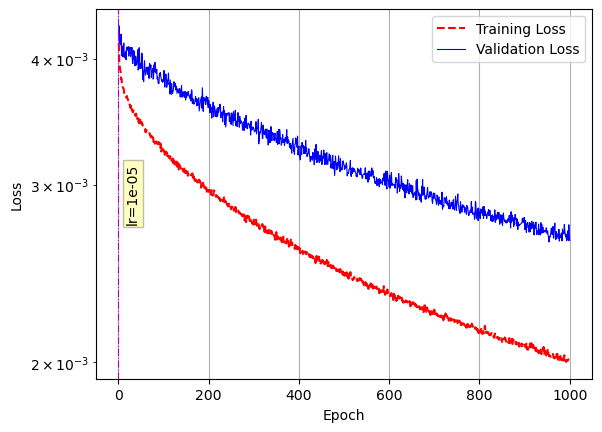

<Figure size 640x480 with 0 Axes>

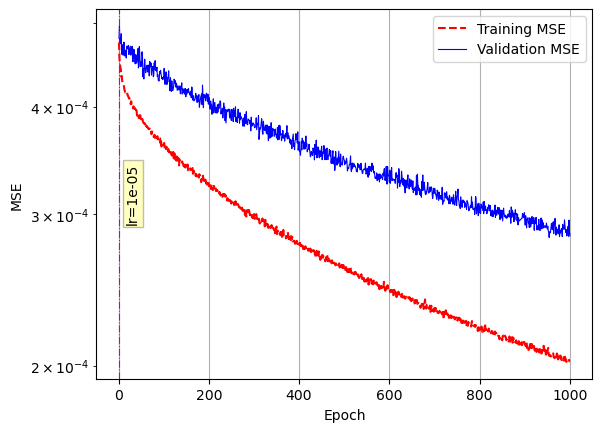

<Figure size 640x480 with 0 Axes>

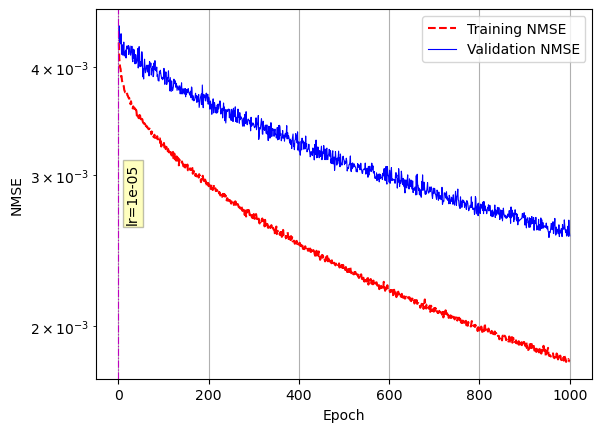

<Figure size 640x480 with 0 Axes>

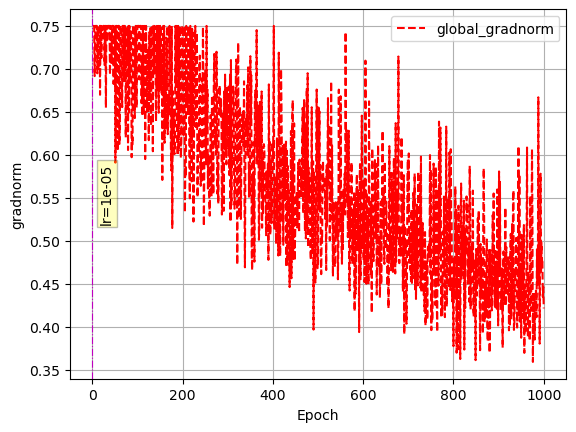

<Figure size 640x480 with 0 Axes>

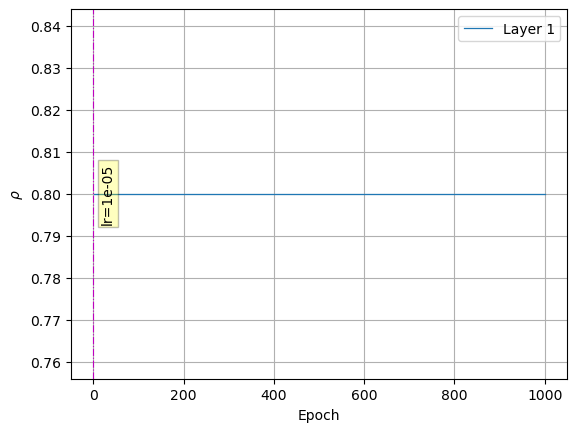

<Figure size 640x480 with 0 Axes>

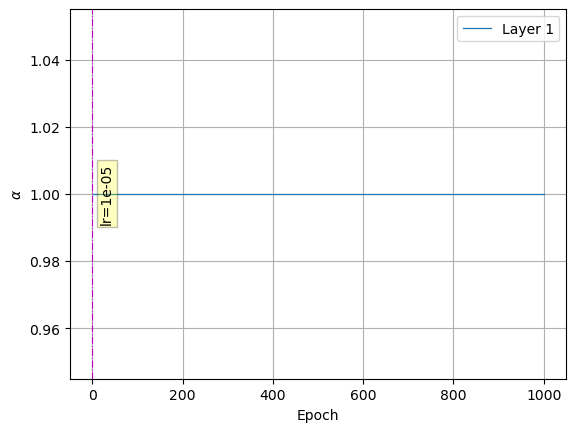

<Figure size 640x480 with 0 Axes>

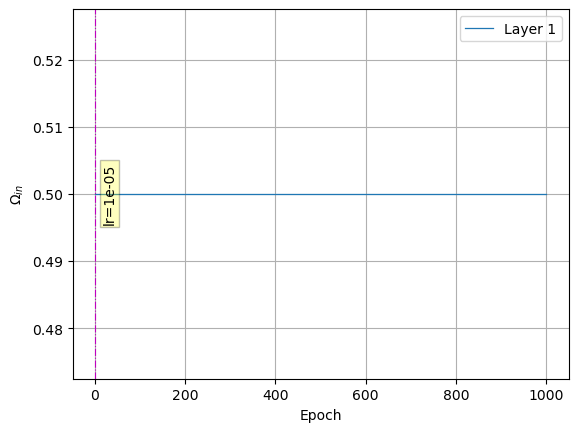



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0091 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 0m 44.3s

Epoch 1: val_NMSE improved from inf to 0.01416, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents

58/58 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0013 - NMSE: 0.0121 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 3.3s

Epoch 9: val_NMSE did not improve from 0.01341
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0083 - mse: 0.0013 - NMSE: 0.0121 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0094 - val_mse: 0.0015 - val_NMSE: 0.0138 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 10/1000
58/58 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0013 - NMSE: 0.0120 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 

Epoch 19/1000
58/58 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0013 - NMSE: 0.0116 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 3m 41.7s

Epoch 19: val_NMSE did not improve from 0.01341
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 169ms/step - loss: 0.0080 - mse: 0.0013 - NMSE: 0.0116 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0093 - val_mse: 0.0015 - val_NMSE: 0.0137 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 20/1000
58/58 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0013 - NMSE: 0.0116 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.75

Epoch 29/1000
58/58 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0013 - NMSE: 0.0113 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 5m 20.9s

Epoch 29: val_NMSE did not improve from 0.01338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0078 - mse: 0.0013 - NMSE: 0.0113 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0091 - val_mse: 0.0015 - val_NMSE: 0.0134 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 30/1000
58/58 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0013 - NMSE: 0.0113 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.75

Epoch 39/1000
58/58 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 6m 59.1s

Epoch 39: val_NMSE did not improve from 0.01322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0076 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0093 - val_mse: 0.0015 - val_NMSE: 0.0137 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 40/1000
58/58 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.75

Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 37.0s

Epoch 49: val_NMSE did not improve from 0.01322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 167ms/step - loss: 0.0075 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0092 - val_mse: 0.0015 - val_NMSE: 0.0135 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 50/1000
58/58 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.75

Epoch 59/1000
58/58 [==============================] - ETA: 0s - loss: 0.0074 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 10m 15.2s

Epoch 59: val_NMSE improved from 0.01318 to 0.01315, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0074 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0090 - val_mse: 0.0015 - val_NMSE: 0.0132 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 60/1000
58/58 [=======

58/58 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 44.0s

Epoch 68: val_NMSE did not improve from 0.01305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0092 - val_mse: 0.0015 - val_NMSE: 0.0134 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 69/1000
58/58 [==============================] - ETA: 0s - loss: 0.0074 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_

Epoch 78/1000
58/58 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 21.8s

Epoch 78: val_NMSE did not improve from 0.01305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 168ms/step - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0091 - val_mse: 0.0015 - val_NMSE: 0.0134 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 79/1000
58/58 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7

Epoch 88/1000
58/58 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 14m 59.0s

Epoch 88: val_NMSE did not improve from 0.01305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0072 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0092 - val_mse: 0.0015 - val_NMSE: 0.0136 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 89/1000
58/58 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7

Epoch 98/1000
58/58 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 16m 37.1s

Epoch 98: val_NMSE did not improve from 0.01305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 167ms/step - loss: 0.0072 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0093 - val_mse: 0.0015 - val_NMSE: 0.0136 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 99/1000
58/58 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7

Epoch 108/1000
58/58 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 18m 15.3s

Epoch 108: val_NMSE improved from 0.01305 to 0.01304, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0014 - val_NMSE: 0.0130 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 109/1000
58/58 [====

Epoch 118/1000
58/58 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 19m 53.8s

Epoch 118: val_NMSE did not improve from 0.01302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 169ms/step - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0090 - val_mse: 0.0015 - val_NMSE: 0.0132 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 119/1000
58/58 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 128/1000
58/58 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 21m 32.4s

Epoch 128: val_NMSE did not improve from 0.01293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 169ms/step - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 129/1000
58/58 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 138/1000
58/58 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 23m 10.8s

Epoch 138: val_NMSE did not improve from 0.01293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 139/1000
58/58 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 148/1000
58/58 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 49.0s

Epoch 148: val_NMSE did not improve from 0.01284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0070 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 149/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 158/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 26m 27.6s

Epoch 158: val_NMSE did not improve from 0.01284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 159/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 168/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 8.8s

Epoch 168: val_NMSE did not improve from 0.01284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0129 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 169/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0013 - global_gradnorm: 0

Epoch 178/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 29m 50.2s

Epoch 178: val_NMSE did not improve from 0.01278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0014 - val_NMSE: 0.0130 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 179/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 188/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 31m 30.7s

Epoch 188: val_NMSE improved from 0.01274 to 0.01273, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 189/1000
58/58 [====

Epoch 198/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 10.2s

Epoch 198: val_NMSE did not improve from 0.01273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0090 - val_mse: 0.0015 - val_NMSE: 0.0132 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 199/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 208/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 34m 49.8s

Epoch 208: val_NMSE did not improve from 0.01273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 209/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 218/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 36m 29.4s

Epoch 218: val_NMSE did not improve from 0.01273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 219/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 228/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 38m 8.8s

Epoch 228: val_NMSE did not improve from 0.01273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 229/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0

Epoch 238/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 48.6s

Epoch 238: val_NMSE did not improve from 0.01272
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0014 - val_NMSE: 0.0130 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 239/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 248/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 41m 28.2s

Epoch 248: val_NMSE did not improve from 0.01271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 249/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 258/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 43m 8.0s

Epoch 258: val_NMSE did not improve from 0.01271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0089 - val_mse: 0.0014 - val_NMSE: 0.0130 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 259/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0

58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 38.1s

Epoch 267: val_NMSE did not improve from 0.01262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0129 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 268/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_re

Epoch 277/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 46m 17.9s

Epoch 277: val_NMSE did not improve from 0.01262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 278/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 287/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 47m 57.7s

Epoch 287: val_NMSE did not improve from 0.01262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0129 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 288/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 297/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 49m 38.4s

Epoch 297: val_NMSE did not improve from 0.01253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 298/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 307/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 51m 18.4s

Epoch 307: val_NMSE did not improve from 0.01253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 308/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 317/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 57.9s

Epoch 317: val_NMSE did not improve from 0.01253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 318/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 327/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 54m 37.0s

Epoch 327: val_NMSE did not improve from 0.01253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 328/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 337/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 56m 16.9s

Epoch 337: val_NMSE did not improve from 0.01253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 338/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 347/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 57m 56.4s

Epoch 347: val_NMSE did not improve from 0.01251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 348/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 357/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 36.4s

Epoch 357: val_NMSE did not improve from 0.01249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 358/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - global_gradnorm: 

Epoch 367/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000   - tot_time: 1h 1m 16.4s

Epoch 367: val_NMSE did not improve from 0.01249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0063 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 368/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0013 - global_gradnorm:

Epoch 377/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 2m 56.6s

Epoch 377: val_NMSE did not improve from 0.01243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 378/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0

Epoch 387/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 35.7s

Epoch 387: val_NMSE did not improve from 0.01242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 169ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 388/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9687e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnor

Epoch 397/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9819e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 15.9s

Epoch 397: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0063 - mse: 9.9819e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 398/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gra

Epoch 407/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9538e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 7m 56.3s

Epoch 407: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0063 - mse: 9.9538e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 408/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9688e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global

Epoch 417/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9928e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 9m 37.2s

Epoch 417: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0063 - mse: 9.9928e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 418/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9665e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global

Epoch 427/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9157e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 17.7s

Epoch 427: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0063 - mse: 9.9157e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 428/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9081e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - globa

Epoch 437/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.8601e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 12m 58.0s

Epoch 437: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0063 - mse: 9.8601e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 438/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.8827e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - globa

Epoch 447/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.8708e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 14m 38.2s

Epoch 447: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0063 - mse: 9.8708e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 448/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.9308e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - globa

Epoch 457/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.8693e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 16m 18.7s

Epoch 457: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0063 - mse: 9.8693e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 458/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 9.8528e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - globa

Epoch 467/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7679e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 58.8s

Epoch 467: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0062 - mse: 9.7679e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 468/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7545e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - globa

Epoch 477/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7659e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 40.1s

Epoch 477: val_NMSE did not improve from 0.01228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0062 - mse: 9.7659e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 478/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7766e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - globa

Epoch 487/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7842e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 21.1s

Epoch 487: val_NMSE did not improve from 0.01228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0062 - mse: 9.7842e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 488/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7509e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - globa

Epoch 497/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7976e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 23m 1.5s

Epoch 497: val_NMSE improved from 0.01228 to 0.01224, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0062 - mse: 9.7976e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0122 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 498/1000
58/5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0062 - mse: 9.6825e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 507/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7206e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 43.2s

Epoch 507: val_NMSE did not improve from 0.01224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outstep

Epoch 516/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.6353e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 13.9s

Epoch 516: val_NMSE did not improve from 0.01224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0061 - mse: 9.6353e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 517/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.6541e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0062 - mse: 9.7218e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0122 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 526/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.6371e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 27m 54.7s

Epoch 526: val_NMSE did not improve from 0.01209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outstep

Epoch 535/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5488e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 29m 24.9s

Epoch 535: val_NMSE did not improve from 0.01209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0061 - mse: 9.5488e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0122 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 536/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.6303e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - globa

Epoch 545/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5884e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 31m 5.7s

Epoch 545: val_NMSE did not improve from 0.01209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0061 - mse: 9.5884e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 546/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5531e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global

Epoch 555/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5944e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 32m 46.9s

Epoch 555: val_NMSE did not improve from 0.01209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0061 - mse: 9.5944e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 556/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5557e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - globa

Epoch 565/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5124e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 34m 28.2s

Epoch 565: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0061 - mse: 9.5124e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 566/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5268e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - globa

Epoch 575/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4367e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 36m 9.1s

Epoch 575: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0060 - mse: 9.4367e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 576/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4801e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global

Epoch 585/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5101e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 37m 49.9s

Epoch 585: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0061 - mse: 9.5101e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 586/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4469e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - globa

Epoch 595/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4862e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 39m 30.9s

Epoch 595: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0060 - mse: 9.4862e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0122 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 596/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4753e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - globa

Epoch 605/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4722e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 41m 11.6s

Epoch 605: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0060 - mse: 9.4722e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 606/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5032e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - globa

Epoch 615/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3594e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 42m 52.1s

Epoch 615: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0060 - mse: 9.3594e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 616/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3777e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - globa

Epoch 625/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4581e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 44m 32.8s

Epoch 625: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0060 - mse: 9.4581e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 626/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3836e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - globa

Epoch 635/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3234e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 46m 13.6s

Epoch 635: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0060 - mse: 9.3234e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 636/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3234e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - globa

Epoch 645/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3704e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 47m 54.9s

Epoch 645: val_NMSE did not improve from 0.01201
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0060 - mse: 9.3704e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 646/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.3098e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - globa

Epoch 655/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.3053e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 49m 36.1s

Epoch 655: val_NMSE did not improve from 0.01201
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0059 - mse: 9.3053e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 656/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.4101e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - globa

Epoch 665/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2886e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 51m 17.0s

Epoch 665: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0059 - mse: 9.2886e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 666/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3360e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - globa

Epoch 675/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.3021e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 52m 57.7s

Epoch 675: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0059 - mse: 9.3021e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0086 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 676/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2717e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - globa

Epoch 685/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.3312e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 54m 39.0s

Epoch 685: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0060 - mse: 9.3312e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 686/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2378e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - globa

Epoch 695/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2449e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 56m 20.4s

Epoch 695: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0059 - mse: 9.2449e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 696/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2367e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - globa

Epoch 705/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2043e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 58m 1.7s

Epoch 705: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0059 - mse: 9.2043e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 706/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2131e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global

Epoch 715/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.2454e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 59m 42.4s

Epoch 715: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0059 - mse: 9.2454e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 716/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1911e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - globa

Epoch 725/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1589e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 1m 23.5s

Epoch 725: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0059 - mse: 9.1589e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 726/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1423e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global

Epoch 735/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.0994e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 3m 4.6s

Epoch 735: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0058 - mse: 9.0994e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 736/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1763e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_

Epoch 745/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.1292e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 4m 45.6s

Epoch 745: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0058 - mse: 9.1292e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 746/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.0849e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global

Epoch 755/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1612e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 6m 26.6s

Epoch 755: val_NMSE did not improve from 0.01191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0059 - mse: 9.1612e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 756/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1678e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global

<Figure size 640x480 with 0 Axes>

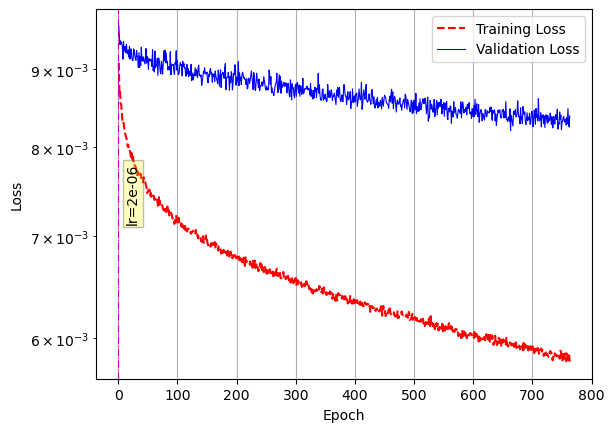

<Figure size 640x480 with 0 Axes>

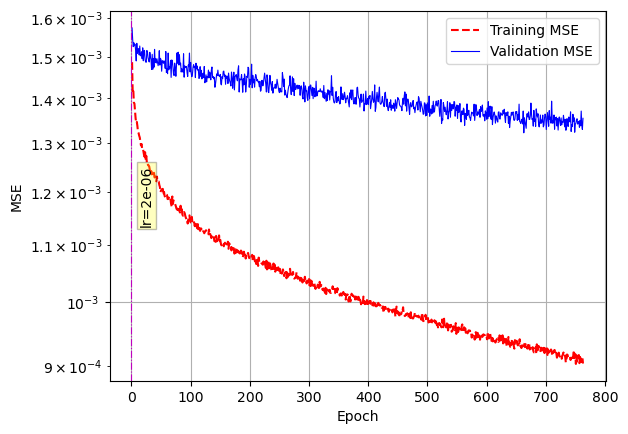

<Figure size 640x480 with 0 Axes>

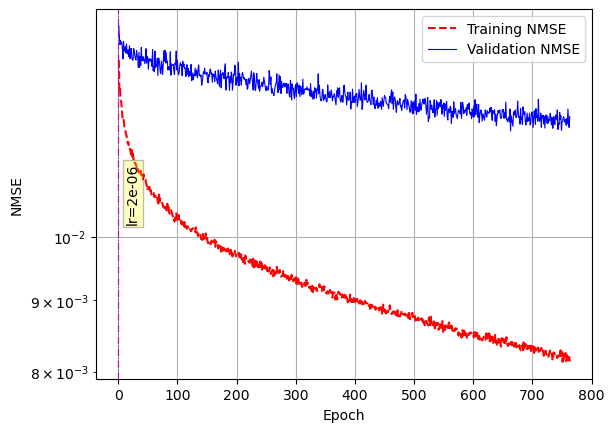

<Figure size 640x480 with 0 Axes>

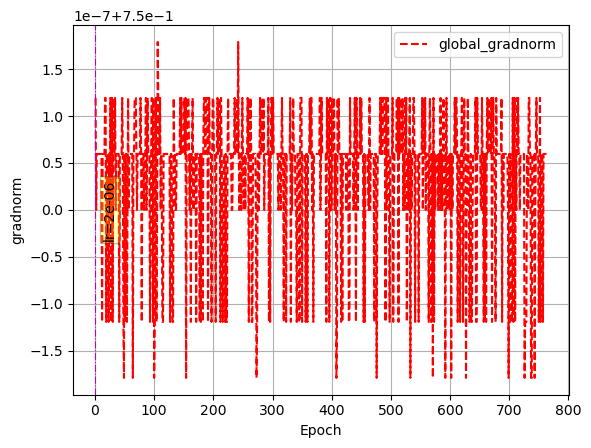

<Figure size 640x480 with 0 Axes>

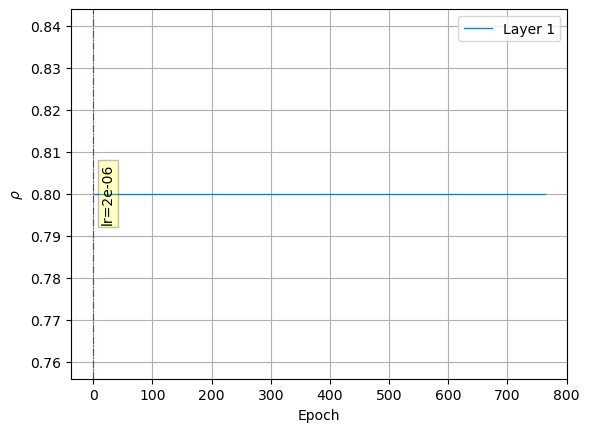

<Figure size 640x480 with 0 Axes>

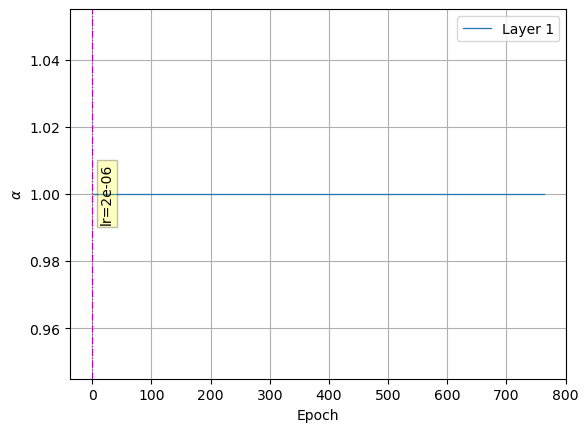

<Figure size 640x480 with 0 Axes>

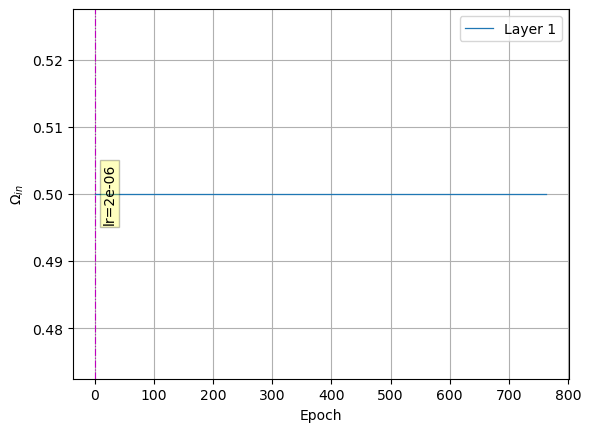



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.75


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0171 - mse: 0.0039 - NMSE: 0.0351 - covmat_fro_loss: 0.0025 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 1m 8.2s

Epoch 1: val_NMSE improved from inf to 0.04470, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/

Epoch 10/1000
49/49 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0035 - NMSE: 0.0313 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 45.9s

Epoch 10: val_NMSE did not improve from 0.04372
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0154 - mse: 0.0035 - NMSE: 0.0313 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0216 - val_mse: 0.0050 - val_NMSE: 0.0446 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 11/1000
49/49 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0035 - NMSE: 0.0311 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.75

Epoch 20/1000
49/49 [==============================] - ETA: 0s - loss: 0.0149 - mse: 0.0034 - NMSE: 0.0302 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 4m 34.2s

Epoch 20: val_NMSE did not improve from 0.04316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0149 - mse: 0.0034 - NMSE: 0.0302 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0210 - val_mse: 0.0048 - val_NMSE: 0.0434 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 21/1000
49/49 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0033 - NMSE: 0.0299 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.75

Epoch 30/1000
49/49 [==============================] - ETA: 0s - loss: 0.0145 - mse: 0.0033 - NMSE: 0.0293 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 6m 22.5s

Epoch 30: val_NMSE did not improve from 0.04305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 218ms/step - loss: 0.0145 - mse: 0.0033 - NMSE: 0.0293 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0214 - val_mse: 0.0049 - val_NMSE: 0.0440 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 31/1000
49/49 [==============================] - ETA: 0s - loss: 0.0145 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.75

Epoch 40/1000
49/49 [==============================] - ETA: 0s - loss: 0.0143 - mse: 0.0032 - NMSE: 0.0287 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 12.0s

Epoch 40: val_NMSE did not improve from 0.04272
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 12s 236ms/step - loss: 0.0143 - mse: 0.0032 - NMSE: 0.0287 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0211 - val_mse: 0.0048 - val_NMSE: 0.0435 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 41/1000
49/49 [==============================] - ETA: 0s - loss: 0.0142 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.75

Epoch 50/1000
49/49 [==============================] - ETA: 0s - loss: 0.0140 - mse: 0.0031 - NMSE: 0.0282 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 10m 1.9s

Epoch 50: val_NMSE did not improve from 0.04215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0140 - mse: 0.0031 - NMSE: 0.0282 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0206 - val_mse: 0.0047 - val_NMSE: 0.0424 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 51/1000
49/49 [==============================] - ETA: 0s - loss: 0.0140 - mse: 0.0031 - NMSE: 0.0281 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.75

Epoch 60/1000
49/49 [==============================] - ETA: 0s - loss: 0.0139 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 52.1s

Epoch 60: val_NMSE did not improve from 0.04184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0139 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0211 - val_mse: 0.0048 - val_NMSE: 0.0435 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 61/1000
49/49 [==============================] - ETA: 0s - loss: 0.0139 - mse: 0.0031 - NMSE: 0.0278 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7

Epoch 70/1000
49/49 [==============================] - ETA: 0s - loss: 0.0138 - mse: 0.0031 - NMSE: 0.0276 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 41.8s

Epoch 70: val_NMSE did not improve from 0.04184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0138 - mse: 0.0031 - NMSE: 0.0276 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0208 - val_mse: 0.0048 - val_NMSE: 0.0429 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 71/1000
49/49 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.0030 - NMSE: 0.0273 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7

Epoch 80/1000
49/49 [==============================] - ETA: 0s - loss: 0.0136 - mse: 0.0030 - NMSE: 0.0273 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 15m 30.5s

Epoch 80: val_NMSE did not improve from 0.04184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0136 - mse: 0.0030 - NMSE: 0.0273 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0205 - val_mse: 0.0047 - val_NMSE: 0.0421 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 81/1000
49/49 [==============================] - ETA: 0s - loss: 0.0136 - mse: 0.0030 - NMSE: 0.0272 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7

Epoch 90/1000
49/49 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0030 - NMSE: 0.0269 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 17m 20.2s

Epoch 90: val_NMSE did not improve from 0.04184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 227ms/step - loss: 0.0135 - mse: 0.0030 - NMSE: 0.0269 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 91/1000
49/49 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7

Epoch 100/1000
49/49 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 19m 9.6s

Epoch 100: val_NMSE did not improve from 0.04174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 222ms/step - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0205 - val_mse: 0.0047 - val_NMSE: 0.0423 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 101/1000
49/49 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0030 - NMSE: 0.0266 - covmat_fro_loss: 0.0023 - global_gradnorm: 0

Epoch 110/1000
49/49 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 58.7s

Epoch 110: val_NMSE did not improve from 0.04174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 218ms/step - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0207 - val_mse: 0.0047 - val_NMSE: 0.0425 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 111/1000
49/49 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0029 - NMSE: 0.0263 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 120/1000
49/49 [==============================] - ETA: 0s - loss: 0.0131 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 22m 48.6s

Epoch 120: val_NMSE did not improve from 0.04174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0131 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0206 - val_mse: 0.0047 - val_NMSE: 0.0424 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 121/1000
49/49 [==============================] - ETA: 0s - loss: 0.0131 - mse: 0.0029 - NMSE: 0.0262 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 130/1000
49/49 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0029 - NMSE: 0.0259 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 38.5s

Epoch 130: val_NMSE did not improve from 0.04162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0130 - mse: 0.0029 - NMSE: 0.0259 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0046 - val_NMSE: 0.0418 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 131/1000
49/49 [==============================] - ETA: 0s - loss: 0.0131 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 140/1000
49/49 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0029 - NMSE: 0.0257 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 26m 28.9s

Epoch 140: val_NMSE did not improve from 0.04151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 222ms/step - loss: 0.0130 - mse: 0.0029 - NMSE: 0.0257 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0419 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 141/1000
49/49 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0028 - NMSE: 0.0256 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 150/1000
49/49 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0029 - NMSE: 0.0258 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 19.3s

Epoch 150: val_NMSE did not improve from 0.04138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0130 - mse: 0.0029 - NMSE: 0.0258 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0416 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 151/1000
49/49 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0028 - NMSE: 0.0255 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 160/1000
49/49 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0028 - NMSE: 0.0256 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 30m 9.2s

Epoch 160: val_NMSE did not improve from 0.04138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0129 - mse: 0.0028 - NMSE: 0.0256 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0418 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 161/1000
49/49 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0028 - NMSE: 0.0253 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 170/1000
49/49 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 31m 58.9s

Epoch 170: val_NMSE did not improve from 0.04133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0127 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 171/1000
49/49 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 180/1000
49/49 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 48.1s

Epoch 180: val_NMSE did not improve from 0.04133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0415 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 181/1000
49/49 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 190/1000
49/49 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0250 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 36.6s

Epoch 190: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0250 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0419 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 191/1000
49/49 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 200/1000
49/49 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 37m 25.5s

Epoch 200: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 201/1000
49/49 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0028 - NMSE: 0.0250 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 210/1000
49/49 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0028 - NMSE: 0.0248 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 15.6s

Epoch 210: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0125 - mse: 0.0028 - NMSE: 0.0248 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0205 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 211/1000
49/49 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 220/1000
49/49 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0027 - NMSE: 0.0247 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 41m 5.5s

Epoch 220: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0125 - mse: 0.0027 - NMSE: 0.0247 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0207 - val_mse: 0.0047 - val_NMSE: 0.0426 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 221/1000
49/49 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 230/1000
49/49 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 42m 55.7s

Epoch 230: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 227ms/step - loss: 0.0125 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0415 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 231/1000
49/49 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 240/1000
49/49 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 45.6s

Epoch 240: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0124 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0419 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 241/1000
49/49 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 250/1000
49/49 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0027 - NMSE: 0.0243 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 46m 35.5s

Epoch 250: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0123 - mse: 0.0027 - NMSE: 0.0243 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0201 - val_mse: 0.0046 - val_NMSE: 0.0412 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 251/1000
49/49 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 260/1000
49/49 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 24.9s

Epoch 260: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0123 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0207 - val_mse: 0.0047 - val_NMSE: 0.0425 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 261/1000
49/49 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 270/1000
49/49 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 50m 14.3s

Epoch 270: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0046 - val_NMSE: 0.0418 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 271/1000
49/49 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0240 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 280/1000
49/49 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0027 - NMSE: 0.0239 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 4.2s

Epoch 280: val_NMSE did not improve from 0.04109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 230ms/step - loss: 0.0121 - mse: 0.0027 - NMSE: 0.0239 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0207 - val_mse: 0.0047 - val_NMSE: 0.0424 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 281/1000
49/49 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0240 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 290/1000
49/49 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 53m 53.3s

Epoch 290: val_NMSE did not improve from 0.04074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0121 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0205 - val_mse: 0.0047 - val_NMSE: 0.0421 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 291/1000
49/49 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 300/1000
49/49 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 41.9s

Epoch 300: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 220ms/step - loss: 0.0121 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0415 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 301/1000
49/49 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 310/1000
49/49 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 57m 29.9s

Epoch 310: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0416 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 311/1000
49/49 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0027 - NMSE: 0.0239 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 320/1000
49/49 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 18.2s

Epoch 320: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 222ms/step - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0237 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0417 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 321/1000
49/49 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0236 - covmat_fro_loss: 0.0022 - global_gradnorm: 

Epoch 330/1000
49/49 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 1m 6.4s

Epoch 330: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0415 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 331/1000
49/49 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0026 - NMSE: 0.0235 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.

Epoch 340/1000
49/49 [==============================] - ETA: 0s - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 2m 54.2s

Epoch 340: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 227ms/step - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0201 - val_mse: 0.0046 - val_NMSE: 0.0412 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 341/1000
49/49 [==============================] - ETA: 0s - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 350/1000
49/49 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 42.3s

Epoch 350: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0416 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 351/1000
49/49 [==============================] - ETA: 0s - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 360/1000
49/49 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 29.7s

Epoch 360: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0419 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 361/1000
49/49 [==============================] - ETA: 0s - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 370/1000
49/49 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 8m 17.5s

Epoch 370: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0200 - val_mse: 0.0045 - val_NMSE: 0.0409 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 371/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 0

Epoch 380/1000
49/49 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 10m 4.9s

Epoch 380: val_NMSE did not improve from 0.04057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0415 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 381/1000
49/49 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0022 - global_gradnorm: 0

Epoch 390/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0230 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 52.1s

Epoch 390: val_NMSE improved from 0.04057 to 0.04035, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0230 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0197 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 391/1000
49/49 [====

Epoch 400/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0230 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 13m 40.3s

Epoch 400: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 222ms/step - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0230 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0047 - val_NMSE: 0.0419 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 401/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 410/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 15m 28.1s

Epoch 410: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0201 - val_mse: 0.0046 - val_NMSE: 0.0413 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 411/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 420/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 16.0s

Epoch 420: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0206 - val_mse: 0.0047 - val_NMSE: 0.0422 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 421/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 430/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 5.1s

Epoch 430: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 222ms/step - loss: 0.0117 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0415 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 431/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0

Epoch 440/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 20m 55.5s

Epoch 440: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 0.0046 - val_NMSE: 0.0418 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 441/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 450/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 22m 45.6s

Epoch 450: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0201 - val_mse: 0.0046 - val_NMSE: 0.0411 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 451/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 460/1000
49/49 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 36.0s

Epoch 460: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0116 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0417 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 461/1000
49/49 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0025 - NMSE: 0.0225 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 470/1000
49/49 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 25.9s

Epoch 470: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0201 - val_mse: 0.0046 - val_NMSE: 0.0411 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 471/1000
49/49 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0025 - NMSE: 0.0225 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 480/1000
49/49 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 16.2s

Epoch 480: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 0.0046 - val_NMSE: 0.0416 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 481/1000
49/49 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 

Epoch 490/1000
49/49 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000Restoring model weights from the end of the best epoch: 390.
 - tot_time: 1h 30m 6.2s

Epoch 490: val_NMSE did not improve from 0.04035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_017/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.7500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0200 - val_mse: 0.0046 - val_NMSE: 0.0410 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 490: early stopping


<Figure size 640x480 with 0 Axes>

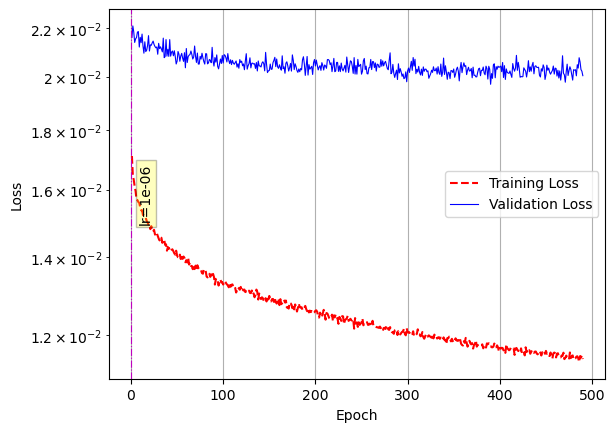

<Figure size 640x480 with 0 Axes>

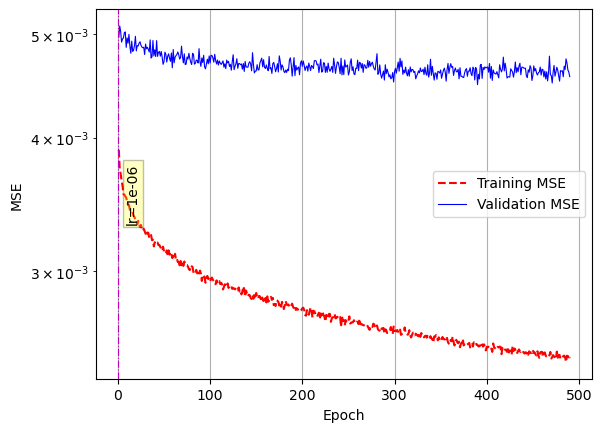

<Figure size 640x480 with 0 Axes>

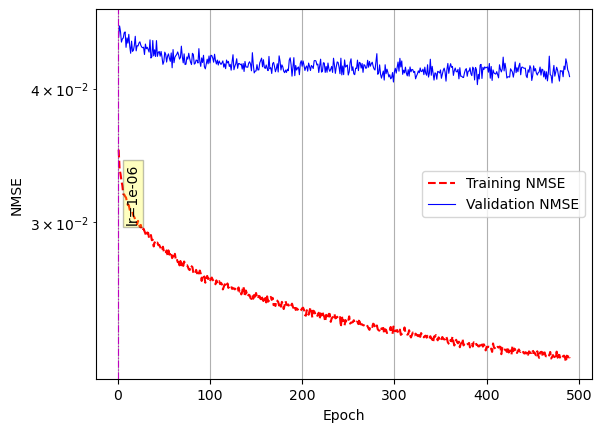

<Figure size 640x480 with 0 Axes>

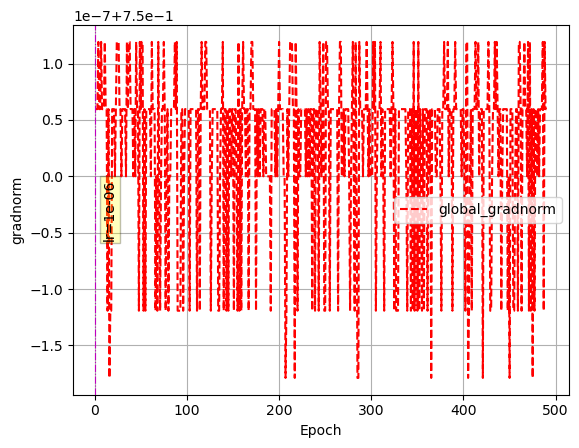

<Figure size 640x480 with 0 Axes>

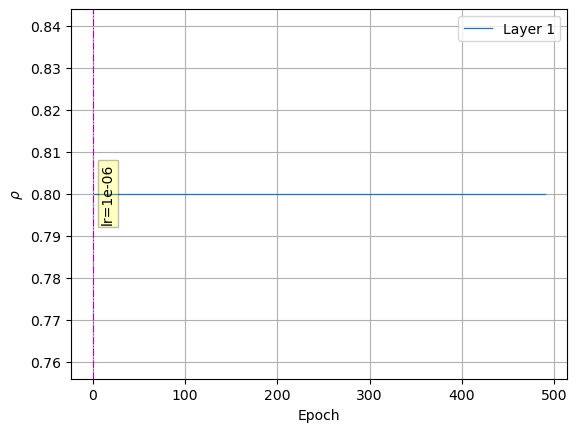

<Figure size 640x480 with 0 Axes>

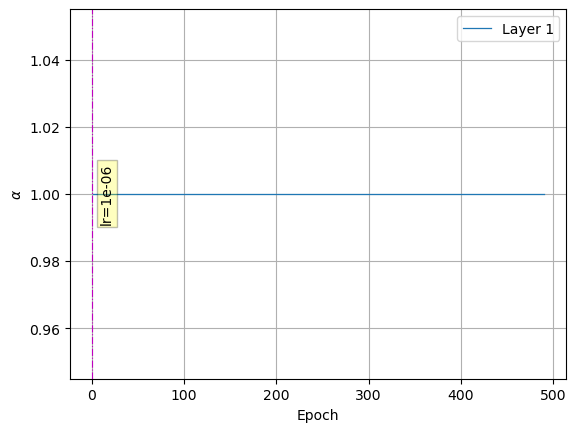

<Figure size 640x480 with 0 Axes>

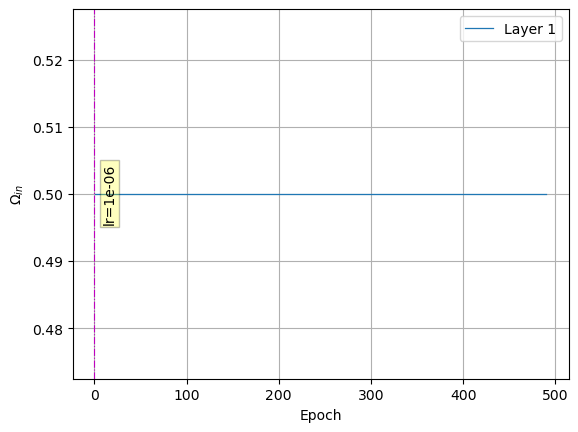

<Figure size 640x480 with 0 Axes>

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [23]:
### Training the combined AE-RNN


# 